# Построение ML-продукта для выявления и оптимизации платежей преподавателей сервиса Repetit.ru

Сервис передает контакты клиента (ученика) репетитору. Если репетитор начинает заниматься с учеником, то он должен платить сервису комиссию от каждого занятия. Но в реальности так происходит не всегда. Иногда, это из-за того, что репетитор звонит по телефону и ему просто не отвечают. Некоторые репетиторы плохо договариваются о занятиях или обманывают. Сервис теряет деньги каждый раз, когда отдаёт заявку неэффективному репетитору. Заказчику нужно как можно раньше понять, что репетитор недобросовестный или мошенник, чтобы отключить его от сервиса и отдавать заявки ответственным репетиторам.

**Задача:** Разработать модель, которая по имеющейся информации о репетиторе и проведенных им занятий будет классифицировать репетиторов на платящих и неэффективных. 

Оценка качества модели будет производиться с использованием метрики `F1`.

**Описание данных**

`Информация о репетиторах (teacher_info.feather):`

- id - айди репетитора 
- reg_date - дата регистрации
- birth_date - дата рождения
- teaching_start_date - дата начала первого занятия
- is_email_confirmed - подтвержден ли e-mail адресс
- lesson_duration - продолжительность урока
- lesson_cost - стоимость урока
- is_display - показывается в каталоге
- last_visited - послеждний визит
- is_pupils_needed - открыт для заявок
- is_cell_phone_confirmed - подтвержден ли номер телефона
- area_id - регион 
- sex - пол 
- orders_allowed - разрешено назначать на заявки
- review_num - отзывы

`Статистика по репетиторам и таргет (teachers.feather):`

- id - айди репетитора 
- lessons_delivered - поставлено уроков
- mean_lesson_price - средняя стоимость уроков
- lessons_given - оплачено уроков
- lessons_started_fraction - процент начала занятий
- lessons_per_pupil - занятий на ученика
- money_recieved - получено денег
- blocked - целевой признак (active/blocked)

`Ученики (lesson_course.feather):`

- Id - айди
- client_id - айди ученика
- teacher_id - айди репетитора
- order_id - айди заявки
- lesson_place - занятия онлайн или офлайн
- lesson_price - цена
- is_active - идут ли занятия, на паузе, завершены
- lesson_duration - продолжительность урока
- date_updated
- suspend_till_date

`Занятия (lessons.feather):`

- Id - айди
- lesson_course_id - айди ученика
- lesson_date - дата
- time_from - время от 
- time_to - время до
- home_task - дз
- is_regular - автоматически повторяющееся занятие
- amount_to_pay - стоимость
- amount_paid - оплачено

`Цены на занятия репетиторов (teacher_prices.feather):`

- date_update - дата обновления цен
- teacher_id - айди репетитора
- subject_id - айди предмета
- price - цена занятий у себя
- price_external - цена занятий на выезде
- price_remote - цена онлайн занятий

`Заявки (orders.feather):`

- order_date - дата создания 
- subject_id - предмет
- purpose - цель занятий
- lesson_price - цена
- lesson_duration - желаемая проодолжительность урока
- home_metro_id - ближайшее метро
- add_info - доп инфо
- start_date
- working_teacher_id
- status_id - оплачена ли заявка (значения 6 и 13 говорят о факте оплаты заявки)
- comments   
- amount_to_pay
- planned_lesson_number - клиент планирует N занятий
- first_lesson_date - дата 1 занятия
- creator_id - кто создал заявку (id сотрудника или клиента)
- pupil_category_new_id - возраст ученика
- lessons_per_week - занятий а неделю
- minimal_price
- teacher_sex - пол репетитора
- teacher_experience_from - опыт репетитора от
- teacher_experience_to- опыт репетитора до
- lesson_place_new - онлайн, у ученика, у учителя
- pupil_knowledgelvl -уровень знаний ученика
- teacher_age_from - желаемый возраст репеитора от
- teacher_age_to - желаемый возраст репеитора от
- chosen_teachers_only - не предлагать репетиторов кроме выбранных самостоятельно
- no_teachers_available - на заявку нет подходящих репов
- source_id - где создана заявка (какая часть сайта, не регион)
- original_order_id - дублем какой заявки является эта заявка
- client_id - айди клиента
- additional_status_id
- max_metro_distance - максимально готов ехать от метро
- estimated_fee 
- payment_date
- test_group - аб тесты
- is_display_to_teachers - хочет ли клиент получать отклики репетиторов

**План реализации:**

- загрузка и ознакомление с данными;
- предварительная обработка и отбор полезных признаков;
- полноценный разведочный анализ (EDA);
- разработка новых синтетических признаков;
- отбор финального набора обучающих признаков;
- выбор и обучение моделей;
- итоговая оценка качества предсказания лучшей модели;
- анализ важности ее признаков;
- подготовка отчета по исследованию.


## Загрузка данных

In [1]:
#!pip install pyarrow
#!pip install phik
#!pip install category_encoders

In [2]:
import pandas as pd
import pyarrow
from pyarrow import feather
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from datetime import date
from datetime import time
import datetime

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder 
from category_encoders import MEstimateEncoder

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, recall_score, f1_score, make_scorer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 120324

### Считаем данные из feather-файлов и сохраним в переменные.

In [3]:
df_lc = pyarrow.feather.read_feather('lesson_course.feather')
df_l = pyarrow.feather.read_feather('lessons.feather')
df_o = pyarrow.feather.read_feather('orders.feather')
df_tp = pyarrow.feather.read_feather('teacher_prices.feather')
df_ti = pyarrow.feather.read_feather('teachers_info.feather')
df_t = pyarrow.feather.read_feather('teachers.feather')

### Выведем общую информацию датафреймов на экран.

#### Для `lesson_course`

In [4]:
df_lc.head()

,id,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date
0,240884,427831.0,133738,718009.0,2,1000,1,60,2021-04-25 23:08:17.883,2018-08-27 00:00:00.000
1,242243,429075.0,106838,720876.0,1,0,0,0,2021-12-03 23:05:52.873,2020-08-01 00:00:00.000
2,242364,429089.0,14700,720912.0,1,0,0,0,2022-05-25 07:27:15.077,2019-09-08 14:22:41.940
3,242476,428940.0,138783,721219.0,1,0,0,0,2021-06-22 20:36:53.287,2018-09-03 00:00:00.000
4,242942,424704.0,3476,720891.0,4,600,0,60,2021-12-19 13:29:29.257,2022-03-20 00:00:00.000


In [5]:
df_lc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893438 entries, 0 to 893437
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 893438 non-null  int64  
 1   client_id          893437 non-null  float64
 2   teacher_id         893438 non-null  int64  
 3   order_id           890132 non-null  float64
 4   lesson_place       893438 non-null  int64  
 5   lesson_price       893438 non-null  int64  
 6   is_active          893438 non-null  int64  
 7   lesson_duration    893438 non-null  int64  
 8   date_updated       893438 non-null  object 
 9   suspend_till_date  893438 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 68.2+ MB


#### Для `lessons`

In [6]:
df_l.head()

,id,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay,amount_paid
0,135797,347,2023-04-14 00:00:00.000,12:45:00,13:50:00,NaN,1,NaN,NaN
1,283596,185756,2022-11-15 00:00:00.000,20:30:00,21:30:00,NaN,0,NaN,NaN
2,322184,184189,2022-12-15 00:00:00.000,16:00:00,17:30:00,NaN,0,NaN,NaN
3,371621,213849,2023-02-13 00:00:00.000,19:30:00,20:30:00,NaN,0,NaN,NaN
4,375586,196475,2023-02-16 00:00:00.000,10:00:00,11:00:00,NaN,0,NaN,NaN


In [7]:
df_l.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191127 entries, 0 to 1191126
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   id                1191127 non-null  int32   
 1   lesson_course_id  1191127 non-null  int32   
 2   lesson_date       1191127 non-null  category
 3   time_from         1191127 non-null  category
 4   time_to           1191127 non-null  category
 5   home_task         4969 non-null     category
 6   is_regular        1191127 non-null  int8    
 7   amount_to_pay     593376 non-null   float64 
 8   amount_paid       8143 non-null     float64 
dtypes: category(4), float64(2), int32(2), int8(1)
memory usage: 37.9 MB


#### Для `orders`

In [8]:
pd.set_option('display.max_columns', None)
df_o.head()

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,None,NaN,None,None,NaN,16,None,NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,None,NaN,None,None,NaN,7,"\n01.11.2022 11:46 - ""Заявка прикреплена к зая...",NaN,0,0,None,NaN,NaN,0,0,3,0,0,0,0,0,0,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ...,800,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 10:37:02.567,143480.0,16,None,NaN,0,7,None,NaN,14.0,2,0,3,0,0,4,0,0,0,0,0,23,NaN,1024439,10.0,NaN,1200,None,1
3,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 00:08:47.437,236392.0,16,None,NaN,0,10,None,47749.0,10.0,3,0,3,5,0,4,0,20,90,0,0,14,2293804.0,1024340,17.0,NaN,2310,None,1
4,2294058,2022-11-01 00:11:49.417,8.0,None,0,60,None,122.0,None,None,NaN,16,Тестовая группа : SplitTestA,NaN,0,0,None,NaN,NaN,0,0,0,0,0,2,0,0,0,0,0,16,NaN,1024440,5.0,NaN,None,None,1


In [9]:
df_o.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teacher_id      4 non-null        float

#### Для `teacher_prices`

In [10]:
df_tp.head()

,date_update,teacher_id,subject_id,price,price_external,price_remote
0,2008-01-20 19:47:18.587,300.0,2,1200,1200,1200
1,2008-01-22 00:33:39.660,125.0,13,0,0,3000
2,2008-01-22 00:33:39.660,125.0,14,0,0,3000
3,2008-01-22 00:37:01.963,91.0,8,2000,0,0
4,2008-02-08 21:27:19.177,372.0,33,400,400,400


In [11]:
df_tp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432422 entries, 0 to 432421
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date_update     432422 non-null  object 
 1   teacher_id      427852 non-null  float64
 2   subject_id      432422 non-null  int64  
 3   price           432422 non-null  int64  
 4   price_external  432422 non-null  int64  
 5   price_remote    432422 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 19.8+ MB


#### Для `teachers_info`

In [12]:
df_ti.head()

,id,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num
0,33,2007-12-24 19:26:46.000,1983-06-05 00:00:00.000,1989-09-01 00:00:00.000,0,60,1000,1,2022-10-24 16:48:38.410,1.0,0,1,1,0,6
1,46,2007-12-24 19:26:46.000,1980-02-12 00:00:00.000,2003-09-01 00:00:00.000,0,60,500,0,None,1.0,0,1,3,1,0
2,51,2007-12-24 19:26:46.000,1965-04-30 00:00:00.000,1988-09-01 00:00:00.000,0,60,1500,0,2022-09-26 09:43:56.123,1.0,0,1,2,1,0
3,52,2007-12-24 19:26:46.000,1988-07-06 00:00:00.000,2006-09-01 00:00:00.000,0,60,1000,1,2020-04-03 15:53:50.867,0.0,0,1,2,1,2
4,54,2007-12-24 19:26:46.000,1985-09-30 00:00:00.000,2004-01-01 00:00:00.000,0,45,400,0,None,1.0,0,1,3,1,0


In [13]:
df_ti.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       307972 non-null  int64  
 1   reg_date                 307972 non-null  object 
 2   birth_date               307972 non-null  object 
 3   teaching_start_date      307972 non-null  object 
 4   is_email_confirmed       307972 non-null  int64  
 5   lesson_duration          307972 non-null  int64  
 6   lesson_cost              307972 non-null  int64  
 7   is_display               307972 non-null  int64  
 8   last_visited             235837 non-null  object 
 9   is_pupils_needed         11208 non-null   float64
 10  is_cell_phone_confirmed  307972 non-null  int64  
 11  area_id                  307972 non-null  int64  
 12  sex                      307972 non-null  int64  
 13  orders_allowed           307972 non-null  int64  
 14  revi

#### Для `teachers`

In [14]:
df_t.head()

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0
1,153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0
2,42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0
3,127280,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0
4,283905,694.0,1252.434457,534.0,0.257143,59.333333,668800.0,0


In [15]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1656 non-null   int64  
 1   lessons_delivered         1656 non-null   float64
 2   mean_lesson_price         1656 non-null   float64
 3   lessons_given             1656 non-null   float64
 4   lessons_started_fraction  1656 non-null   float64
 5   lessons_per_pupil         1656 non-null   float64
 6   money_recieved            1656 non-null   float64
 7   blocked                   1656 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 103.6 KB


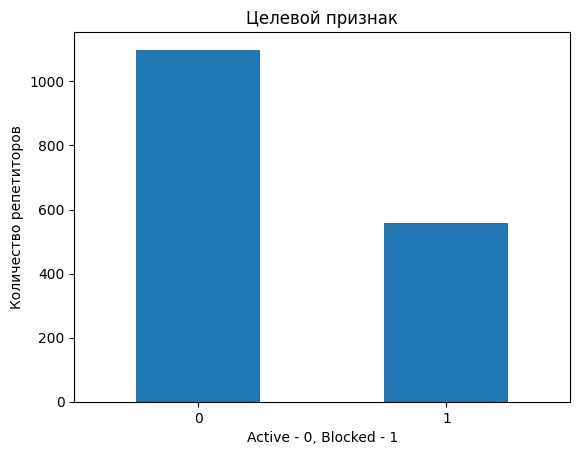

In [16]:
df_t['blocked'].value_counts().plot.bar()
plt.title("Целевой признак")
plt.ylabel('Количество репетиторов')
plt.xlabel('Active - 0, Blocked - 1')
plt.xticks(rotation=0)
plt.show()

### Объединим таблицы

In [17]:
# Удалим строки в которых нет значения teacher_id в таблице df_tp
df_tp = df_tp.dropna(subset=['teacher_id']).reset_index(drop=True)
df_tp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427852 entries, 0 to 427851
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date_update     427852 non-null  object 
 1   teacher_id      427852 non-null  float64
 2   subject_id      427852 non-null  int64  
 3   price           427852 non-null  int64  
 4   price_external  427852 non-null  int64  
 5   price_remote    427852 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 19.6+ MB


In [18]:
# Поменяем тип с float на int в df_tp 
df_tp['teacher_id'] = df_tp['teacher_id'].astype('int64')
df_tp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427852 entries, 0 to 427851
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   date_update     427852 non-null  object
 1   teacher_id      427852 non-null  int64 
 2   subject_id      427852 non-null  int64 
 3   price           427852 non-null  int64 
 4   price_external  427852 non-null  int64 
 5   price_remote    427852 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 19.6+ MB


In [19]:
print(df_ti.id.nunique())
print(df_t.id.nunique())

307972
1656


In [20]:
# Объединим таблицы с информацией по репетиторам df_t и df_ti
df_merged_teachers_1 = pd.merge(df_t, df_ti, left_on='id', right_on='id', how='left', suffixes=('_teachers', '_teacher_info'))
df_merged_teachers_1.head()

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16 00:00:00.000,2017-09-01 00:00:00.000,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0
1,153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0,2018-10-19 20:23:24.157,1968-03-10 00:00:00.000,1985-09-01 00:00:00.000,0.0,60.0,600.0,1.0,2022-10-22 16:16:44.800,NaN,0.0,13.0,2.0,1.0,26.0
2,42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0,2012-09-20 20:42:52.000,1965-04-20 00:00:00.000,2002-09-01 00:00:00.000,0.0,60.0,2500.0,1.0,2022-10-22 21:21:47.523,NaN,0.0,2.0,2.0,1.0,64.0
3,127280,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0,2017-09-06 16:51:20.000,1986-05-07 00:00:00.000,2005-09-01 00:00:00.000,0.0,60.0,1500.0,1.0,2022-03-17 22:50:23.267,NaN,0.0,1.0,2.0,1.0,10.0
4,283905,694.0,1252.434457,534.0,0.257143,59.333333,668800.0,0,2023-01-18 13:16:08.137,1973-09-14 00:00:00.000,1992-09-01 00:00:00.000,0.0,45.0,1178.0,1.0,None,NaN,0.0,116.0,2.0,1.0,1.0


In [21]:
df_merged_teachers_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1656 non-null   int64  
 1   lessons_delivered         1656 non-null   float64
 2   mean_lesson_price         1656 non-null   float64
 3   lessons_given             1656 non-null   float64
 4   lessons_started_fraction  1656 non-null   float64
 5   lessons_per_pupil         1656 non-null   float64
 6   money_recieved            1656 non-null   float64
 7   blocked                   1656 non-null   int64  
 8   reg_date                  1602 non-null   object 
 9   birth_date                1602 non-null   object 
 10  teaching_start_date       1602 non-null   object 
 11  is_email_confirmed        1602 non-null   float64
 12  lesson_duration           1602 non-null   float64
 13  lesson_cost               1602 non-null   float64
 14  is_displ

In [22]:
# Переименуем название столбца
df_merged_teachers_1.rename(columns={'id' : 'teacher_id'}, inplace=True)
df_merged_teachers_1.head()

,teacher_id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16 00:00:00.000,2017-09-01 00:00:00.000,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0
1,153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0,2018-10-19 20:23:24.157,1968-03-10 00:00:00.000,1985-09-01 00:00:00.000,0.0,60.0,600.0,1.0,2022-10-22 16:16:44.800,NaN,0.0,13.0,2.0,1.0,26.0
2,42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0,2012-09-20 20:42:52.000,1965-04-20 00:00:00.000,2002-09-01 00:00:00.000,0.0,60.0,2500.0,1.0,2022-10-22 21:21:47.523,NaN,0.0,2.0,2.0,1.0,64.0
3,127280,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0,2017-09-06 16:51:20.000,1986-05-07 00:00:00.000,2005-09-01 00:00:00.000,0.0,60.0,1500.0,1.0,2022-03-17 22:50:23.267,NaN,0.0,1.0,2.0,1.0,10.0
4,283905,694.0,1252.434457,534.0,0.257143,59.333333,668800.0,0,2023-01-18 13:16:08.137,1973-09-14 00:00:00.000,1992-09-01 00:00:00.000,0.0,45.0,1178.0,1.0,None,NaN,0.0,116.0,2.0,1.0,1.0


In [23]:
# Объединим таблицы с информацией по репетиторам df_merged_teachers_1 и df_tp
df_merged_teachers = pd.merge(df_merged_teachers_1, df_tp, left_on='teacher_id', right_on='teacher_id', how='left', suffixes=('_merged_teachers_1', '_teacher_prices'))
df_merged_teachers.head()

,teacher_id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num,date_update,subject_id,price,price_external,price_remote
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16 00:00:00.000,2017-09-01 00:00:00.000,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,9,1700,0,1700
1,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16 00:00:00.000,2017-09-01 00:00:00.000,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,8,1700,0,1700
2,153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0,2018-10-19 20:23:24.157,1968-03-10 00:00:00.000,1985-09-01 00:00:00.000,0.0,60.0,600.0,1.0,2022-10-22 16:16:44.800,NaN,0.0,13.0,2.0,1.0,26.0,2018-11-14 18:54:44.113,18,0,0,1200
3,42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0,2012-09-20 20:42:52.000,1965-04-20 00:00:00.000,2002-09-01 00:00:00.000,0.0,60.0,2500.0,1.0,2022-10-22 21:21:47.523,NaN,0.0,2.0,2.0,1.0,64.0,2012-09-20 20:42:52.390,3,0,0,2500
4,127280,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0,2017-09-06 16:51:20.000,1986-05-07 00:00:00.000,2005-09-01 00:00:00.000,0.0,60.0,1500.0,1.0,2022-03-17 22:50:23.267,NaN,0.0,1.0,2.0,1.0,10.0,2017-09-06 16:51:20.087,2,2500,3000,2500


In [24]:
df_merged_teachers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3064 entries, 0 to 3063
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   teacher_id                3064 non-null   int64  
 1   lessons_delivered         3064 non-null   float64
 2   mean_lesson_price         3064 non-null   float64
 3   lessons_given             3064 non-null   float64
 4   lessons_started_fraction  3064 non-null   float64
 5   lessons_per_pupil         3064 non-null   float64
 6   money_recieved            3064 non-null   float64
 7   blocked                   3064 non-null   int64  
 8   reg_date                  2978 non-null   object 
 9   birth_date                2978 non-null   object 
 10  teaching_start_date       2978 non-null   object 
 11  is_email_confirmed        2978 non-null   float64
 12  lesson_duration           2978 non-null   float64
 13  lesson_cost               2978 non-null   float64
 14  is_displ

In [25]:
# Объединим таблицы с информацией по ученикам
df_merged_lessons = pd.merge(df_lc, df_l, left_on='id', right_on='lesson_course_id', how='left', suffixes=('_lesson_course', '_lessons'))
df_merged_lessons.head()

,id_lesson_course,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date,id_lessons,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay,amount_paid
0,240884,427831.0,133738,718009.0,2,1000,1,60,2021-04-25 23:08:17.883,2018-08-27 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,242243,429075.0,106838,720876.0,1,0,0,0,2021-12-03 23:05:52.873,2020-08-01 00:00:00.000,1614162.0,242243.0,2021-12-02 00:00:00.000,10:00:00,11:00:00,NaN,0.0,NaN,NaN
2,242243,429075.0,106838,720876.0,1,0,0,0,2021-12-03 23:05:52.873,2020-08-01 00:00:00.000,2078365.0,242243.0,2022-05-20 00:00:00.000,11:00:00,12:00:00,NaN,0.0,NaN,NaN
3,242364,429089.0,14700,720912.0,1,0,0,0,2022-05-25 07:27:15.077,2019-09-08 14:22:41.940,1849169.0,242364.0,2021-10-05 00:00:00.000,18:00:00,19:00:00,NaN,1.0,NaN,NaN
4,242364,429089.0,14700,720912.0,1,0,0,0,2022-05-25 07:27:15.077,2019-09-08 14:22:41.940,1885812.0,242364.0,2021-10-16 00:00:00.000,18:00:00,19:00:00,NaN,0.0,NaN,NaN


In [26]:
df_merged_lessons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1835766 entries, 0 to 1835765
Data columns (total 19 columns):
 #   Column             Dtype   
---  ------             -----   
 0   id_lesson_course   int64   
 1   client_id          float64 
 2   teacher_id         int64   
 3   order_id           float64 
 4   lesson_place       int64   
 5   lesson_price       int64   
 6   is_active          int64   
 7   lesson_duration    int64   
 8   date_updated       object  
 9   suspend_till_date  object  
 10  id_lessons         float64 
 11  lesson_course_id   float64 
 12  lesson_date        category
 13  time_from          category
 14  time_to            category
 15  home_task          category
 16  is_regular         float64 
 17  amount_to_pay      float64 
 18  amount_paid        float64 
dtypes: category(4), float64(7), int64(6), object(2)
memory usage: 224.5+ MB


In [27]:
# Объединим таблицы с информацией по репетиторам и по урокам
df_merged = pd.merge(df_merged_teachers, df_merged_lessons, left_on='teacher_id', right_on='teacher_id', how='left', suffixes=('_merged_teachers', '_merged_lessons'))
df_merged.head()

,teacher_id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration_merged_teachers,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num,date_update,subject_id,price,price_external,price_remote,id_lesson_course,client_id,order_id,lesson_place,lesson_price,is_active,lesson_duration_merged_lessons,date_updated,suspend_till_date,id_lessons,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay,amount_paid
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16 00:00:00.000,2017-09-01 00:00:00.000,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,9,1700,0,1700,618562.0,714844.0,1423591.0,4.0,1000.0,0.0,90.0,2020-09-12 17:01:46.933,1800-01-01 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16 00:00:00.000,2017-09-01 00:00:00.000,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,9,1700,0,1700,614981.0,612745.0,1417418.0,5.0,600.0,0.0,60.0,2020-09-02 23:59:37.230,1800-01-01 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16 00:00:00.000,2017-09-01 00:00:00.000,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,9,1700,0,1700,786638.0,829247.0,1730447.0,4.0,800.0,1.0,60.0,2021-08-20 14:06:31.987,1800-01-01 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16 00:00:00.000,2017-09-01 00:00:00.000,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,9,1700,0,1700,804116.0,839138.0,1759764.0,4.0,1000.0,0.0,60.0,2021-09-09 13:23:49.193,1800-01-01 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16 00:00:00.000,2017-09-01 00:00:00.000,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,9,1700,0,1700,1014712.0,975583.0,2148007.0,4.0,1300.0,0.0,60.0,2022-08-25 20:48:47.417,1800-01-01 00:00:00.000,2655805.0,1014712.0,2022-08-26 00:00:00.000,20:00:00,21:00:00,NaN,0.0,1300.0,1300.0


In [28]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800329 entries, 0 to 800328
Data columns (total 45 columns):
 #   Column                           Non-Null Count   Dtype   
---  ------                           --------------   -----   
 0   teacher_id                       800329 non-null  int64   
 1   lessons_delivered                800329 non-null  float64 
 2   mean_lesson_price                800329 non-null  float64 
 3   lessons_given                    800329 non-null  float64 
 4   lessons_started_fraction         800329 non-null  float64 
 5   lessons_per_pupil                800329 non-null  float64 
 6   money_recieved                   800329 non-null  float64 
 7   blocked                          800329 non-null  int64   
 8   reg_date                         800243 non-null  object  
 9   birth_date                       800243 non-null  object  
 10  teaching_start_date              800243 non-null  object  
 11  is_email_confirmed               800243 non-null  fl

In [29]:
# Объединим таблицы с информацией по заявкам
df = pd.merge(df_merged, df_o, left_on='client_id', right_on='client_id', suffixes=('__merged', '_orders'))
df.head()

,teacher_id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration_merged_teachers,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num,date_update,subject_id__merged,price,price_external,price_remote,id_lesson_course,client_id,order_id,lesson_place__merged,lesson_price__merged,is_active,lesson_duration_merged_lessons,date_updated,suspend_till_date,id_lessons,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay__merged,amount_paid,id,order_date,subject_id_orders,purpose,lesson_price_orders,lesson_duration,lesson_place_orders,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay_orders,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16 00:00:00.000,2017-09-01 00:00:00.000,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,9,1700,0,1700,804116.0,839138.0,1759764.0,4.0,1000.0,0.0,60.0,2021-09-09 13:23:49.193,1800-01-01 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1759764,2021-09-08 19:33:21.360,8.0,"Разделы: алгебра, геометрия.\nКатегория ученик...",1000,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2021-09-09 13:29:32.710,198013.0,16,None,NaN,0,10,None,NaN,9.0,4,500,3,0,0,4,0,16,90,0,0,23,NaN,13.0,NaN,3200,None,1
1,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16 00:00:00.000,2017-09-01 00:00:00.000,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,9,1700,0,1700,804116.0,839138.0,1759764.0,4.0,1000.0,0.0,60.0,2021-09-09 13:23:49.193,1800-01-01 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1759789,2021-09-08 19:41:59.130,8.0,"улучшить оценки, успеваемость",0,60,None,NaN,Понедельник после 18-00; вторник после 18-00,None,NaN,7,"\n09.09.2021 7:31 - ""Заявка прикреплена к заяв...",NaN,0,10,None,843206.0,9.0,4,0,0,0,0,4,0,16,90,0,0,23,1759764.0,7.0,NaN,None,None,1
2,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16 00:00:00.000,2017-09-01 00:00:00.000,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,9,1700,0,1700,804116.0,839138.0,1759764.0,4.0,1000.0,0.0,60.0,2021-09-09 13:23:49.193,1800-01-01 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1761285,2021-09-09 13:14:08.077,8.0,"улучшить оценки, успеваемость",0,60,None,NaN,Понедельник после 18-00; вторник после 18-00,None,NaN,7,"\n09.09.2021 13:21 - ""Заявка прикреплена к зая...",NaN,0,10,None,843206.0,9.0,4,0,0,0,0,4,0,16,90,0,0,23,1759764.0,7.0,NaN,None,None,1
3,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16 00:00:00.000,2017-09-01 00:00:00.000,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,9,1700,0,1700,804116.0,839138.0,1759764.0,4.0,1000.0,0.0,60.0,2021-09-09 13:23:49.193,1800-01-01 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1761293,2021-09-09 13:15:03.837,8.0,"улучшить оценки, успеваемость",0,60,None,NaN,Понедельник после 18-00; вторник после 18-00,None,NaN,7,"\n09.09.2021 13:21 - ""Заявка прикреплена к зая...",NaN,0,10,None,843206.0,9.0,4,0,0,0,0,4,0,16,90,0,0,23,1759764.0,7.0,NaN,None,None,1
4,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16 00:00:00.000,2017-09-01 00:00:00.000,0.0,60.0,800.0

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3647850 entries, 0 to 3647849
Data columns (total 82 columns):
 #   Column                           Dtype   
---  ------                           -----   
 0   teacher_id                       int64   
 1   lessons_delivered                float64 
 2   mean_lesson_price                float64 
 3   lessons_given                    float64 
 4   lessons_started_fraction         float64 
 5   lessons_per_pupil                float64 
 6   money_recieved                   float64 
 7   blocked                          int64   
 8   reg_date                         object  
 9   birth_date                       object  
 10  teaching_start_date              object  
 11  is_email_confirmed               float64 
 12  lesson_duration_merged_teachers  float64 
 13  lesson_cost                      float64 
 14  is_display                       float64 
 15  last_visited                     object  
 16  is_pupils_needed                 flo

Посмотрим процент пропусков в полученных столбцах.

In [31]:
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
teacher_id,0.000000
lessons_delivered,0.000000
mean_lesson_price,0.000000
lessons_given,0.000000
lessons_started_fraction,0.000000
lessons_per_pupil,0.000000
money_recieved,0.000000
blocked,0.000000
reg_date,0.000000
birth_date,0.000000


Таблицы объединили, видим, что есть много пропусков, далее рассмотрим их поближе.

### Выполним предобработку данных

**Проверим наличие дубликатов.**

In [32]:
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 3213


In [33]:
df[df.duplicated (keep='last')].head(10)

,teacher_id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration_merged_teachers,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num,date_update,subject_id__merged,price,price_external,price_remote,id_lesson_course,client_id,order_id,lesson_place__merged,lesson_price__merged,is_active,lesson_duration_merged_lessons,date_updated,suspend_till_date,id_lessons,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay__merged,amount_paid,id,order_date,subject_id_orders,purpose,lesson_price_orders,lesson_duration,lesson_place_orders,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay_orders,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
16646,42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0,2012-09-20 20:42:52.000,1965-04-20 00:00:00.000,2002-09-01 00:00:00.000,0.0,60.0,2500.0,1.0,2022-10-22 21:21:47.523,NaN,0.0,2.0,2.0,1.0,64.0,2012-09-20 20:42:52.390,3,0,0,2500,1145354.0,1063026.0,2399409.0,4.0,3000.0,0.0,60.0,2023-01-07 20:25:04.270,1800-01-01 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2399335,2023-01-07 19:26:51.527,3.0,Разделы: общий курс.\nДополнения: Goethe-Zerti...,3000,60,None,NaN,Стоимость занятий обсуждается.\nМесто проведен...,2023-01-07 20:23:54.693,79384.0,16,None,NaN,0,10,None,NaN,10.0,3,1000,3,5,0,4,2,25,50,0,0,23,NaN,10.0,NaN,9600,None,1
16647,42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0,2012-09-20 20:42:52.000,1965-04-20 00:00:00.000,2002-09-01 00:00:00.000,0.0,60.0,2500.0,1.0,2022-10-22 21:21:47.523,NaN,0.0,2.0,2.0,1.0,64.0,2012-09-20 20:42:52.390,3,0,0,2500,1145354.0,1063026.0,2399409.0,4.0,3000.0,0.0,60.0,2023-01-07 20:25:04.270,1800-01-01 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2399409,2023-01-07 20:23:57.917,3.0,Разделы: общий курс.\nДополнения: Goethe-Zerti...,3000,60,None,NaN,Стоимость занятий обсуждается.\nМесто проведен...,2023-01-07 20:27:56.403,42869.0,16,None,NaN,0,10,None,816271.0,10.0,3,1000,3,5,0,4,2,25,50,0,0,14,2399335.0,13.0,NaN,0,None,1
105283,244419,626.0,1424.421594,389.0,0.275862,48.625000,554100.0,0,2021-09-30 09:10:47.260,1977-06-09 00:00:00.000,2010-09-01 00:00:00.000,0.0,60.0,1000.0,1.0,2022-10-13 15:31:44.117,NaN,0.0,1.0,2.0,1.0,6.0,2021-09-30 09:20:16.720,2,1500,0,1500,1064884.0,605223.0,2241658.0,4.0,1500.0,0.0,60.0,2022-10-06 15:58:42.067,1800-01-01 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2398682,2023-01-07 10:31:23.917,2.0,Цели: улучшить успеваемость.\nКатегория ученик...,1500,60,None,NaN,"Желаемое время для занятий: вторник - 14, 15; ...",2023-01-07 10:39:56.260,227504.0,6,None,NaN,1800,10,2023-01-08 00:00:00.000,551062.0,5.0,0,0,3,1,0,4,2,0,0,0,0,23,2391442.0,NaN,NaN,2250,2023-01-11 18:22:04.720,1
105296,224381,1655.0,1539.434629,1415.0,0.328671,30.106383,2178300.0,0,2021-01-30 17:56:44.943,1989-02-12 00:00:00.000,2012-09-01 00:00:00.000,0.0,60.0,1500.0,1.0,2022-10-23 23:32:38.360,NaN,0.0,1.0,1.0,1.0,38.0,2021-02-01 13:25:04.600,2,0,0,1700,1064882.0,605223.0,2241657.0,4.0,1500.0,0.0,60.0,2022-10-06 15:58:22.750,1800-01-01 00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2398682,2023-01-07 10:31:23.917,2.0,Цели: улучшить успеваемость.\nКатегория ученик...,1500,60,None,NaN,"Желаемое время для занятий: вторник - 14, 15; ...",2023-01-07 10:39:56.260,227504.0,6,None,NaN,1800,10,2023-01-08 00:00:00.000,551062.0,5.0,0,0,3,1,0,4,2,0,0,0,0,23,2391442.0,NaN,NaN,2250,2023-01-11 18:22:04.720,1
105309,224381,1655.0,1539.434629,1415.0,0

In [34]:
# Удалим дубликаты
df = df.drop_duplicates()
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 0


#### Изменим тип даты на *datetime*.

In [35]:
df['lesson_date'] = df['lesson_date'].astype('object')
df['time_from'] = df['time_from'].astype('object')
df['time_to'] = df['time_to'].astype('object')

In [36]:
date_columns = ['reg_date',
                'birth_date',
                'teaching_start_date',
                'last_visited',
                'lesson_date',
                'date_updated',
                'suspend_till_date',
                'date_update',
                'order_date',
                'start_date',
                'first_lesson_date',
                'payment_date']

In [37]:
pd.DataFrame(round(df[date_columns].isna().mean()*100,)).style.background_gradient('coolwarm')

,0
reg_date,0.000000
birth_date,0.000000
teaching_start_date,0.000000
last_visited,6.000000
lesson_date,22.000000
date_updated,0.000000
suspend_till_date,0.000000
date_update,0.000000
order_date,0.000000
start_date,25.000000


In [38]:
df = df.dropna(subset=['last_visited', 'lesson_date'])

In [39]:
def date(x):
    return pd.to_datetime(x, format='mixed', yearfirst=True)

In [40]:
df[date_columns] = df[date_columns].apply(date)

In [41]:
now = pd.to_datetime('2024-01-31') # примем день выгрузки данных 2024-01-31

Создадим столбец с днями, прошедшими от заявки до урока

In [42]:
df['days_from_order_to_lesson'] = (df['lesson_date'] - df['order_date']).dt.days
df['days_from_order_to_lesson'] = df['days_from_order_to_lesson'].astype('int64')

Добавим столбец с примерным возрастом учителя

In [43]:
df['teacher_age'] = (((now - df['birth_date']).dt.days) / 365).astype('int64')

Добавим столбец с опытом преподавания учителя в годах

In [44]:
df['teaching experience'] = round((((now - df['teaching_start_date']).dt.days) / 365), 2)

Добавим столбец с количеством лет, прошедших после регистрации на платформе

In [45]:
df['teacher_reg'] = round((((now - df['reg_date']).dt.days) / 365), 2)

Добавим столбец с разницей между началом и концом занятия

In [46]:
df['time_from'] = pd.to_timedelta(df['time_from'])
df['time_to'] = pd.to_timedelta(df['time_to'])

In [47]:
def time_from_to(row):
    if row['time_to'] > row['time_from']:
        return (row['time_to'] - row['time_from']) / pd.Timedelta(minutes=1)
    else: 
        return ((row['time_to'] / pd.Timedelta(minutes=1) + 1440) - (row['time_from'] / pd.Timedelta(minutes=1))) # если время time_from = 22:00:00, а time_to = 00:00:00, 
                                                                                                                  # то разница должна быть 2 часа (120 минут), а не 22 часа (1320 минут), поэтому добавим к time_to + 24 часа (1440 минут)

In [48]:
df['time_from_to'] = df.apply(time_from_to, axis=1)

In [49]:
df['time_from_to'] = df['time_from_to'].astype('int64')

Добавим столбец с разницей между прошедшим уроком и последним визитом

In [50]:
df['days_after_lesson'] = ((df['last_visited'] - df['lesson_date']).dt.days).astype('int64')

In [51]:
df.head()

,teacher_id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration_merged_teachers,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num,date_update,subject_id__merged,price,price_external,price_remote,id_lesson_course,client_id,order_id,lesson_place__merged,lesson_price__merged,is_active,lesson_duration_merged_lessons,date_updated,suspend_till_date,id_lessons,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay__merged,amount_paid,id,order_date,subject_id_orders,purpose,lesson_price_orders,lesson_duration,lesson_place_orders,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay_orders,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers,days_from_order_to_lesson,teacher_age,teaching experience,teacher_reg,time_from_to,days_after_lesson
10,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16,2017-09-01,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,9,1700,0,1700,1014712.0,975583.0,2148007.0,4.0,1300.0,0.0,60.0,2022-08-25 20:48:47.417,1800-01-01,2655805.0,1014712.0,2022-08-26,0 days 20:00:00,0 days 21:00:00,NaN,0.0,1300.0,1300.0,2148007,2022-08-25 19:35:51.887,8.0,"Разделы: школьный курс, алгебра, геометрия.\n...",1500,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-08-25 19:59:30.957,198013.0,6,None,NaN,0,10,2022-08-26,NaN,12.0,2,1000,3,0,0,4,0,0,35,0,0,23,NaN,NaN,NaN,None,NaT,1,0,26,6.42,3.82,60,56
11,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16,2017-09-01,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,8,1700,0,1700,1014712.0,975583.0,2148007.0,4.0,1300.0,0.0,60.0,2022-08-25 20:48:47.417,1800-01-01,2655805.0,1014712.0,2022-08-26,0 days 20:00:00,0 days 21:00:00,NaN,0.0,1300.0,1300.0,2148007,2022-08-25 19:35:51.887,8.0,"Разделы: школьный курс, алгебра, геометрия.\n...",1500,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-08-25 19:59:30.957,198013.0,6,None,NaN,0,10,2022-08-26,NaN,12.0,2,1000,3,0,0,4,0,0,35,0,0,23,NaN,NaN,NaN,None,NaT,1,0,26,6.42,3.82,60,56
12,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16,2017-09-01,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,9,1700,0,1700,1016021.0,976426.0,2150543.0,4.0,1000.0,1.0,60.0,2023-05-24 19:54:27.013,2023-09-01,2658003.0,1016021.0,2022-09-05,0 days 19:30:00,0 days 20:30:00,NaN,0.0,1000.0,1000.0,2150282,2022-08-27 14:07:13.853,8.0,Разделы: школьный курс.\nДополнения: ОГЭ (ГИА...,1000,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-08-27 15:40:57.173,256100.0,16,Тестовая группа : SplitTestA\n?Статус дозаполн...,NaN,0,10,NaT,NaN,10.0,5,0,1,0,0,4,0,0,30,0,0,16,NaN,13.0,NaN,0,NaT,1,8,26,6.42,3.82,60,46
13,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16,2017-09-01,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,9,1700,0,1700,1016021.0,976426.0,2150543.0,4.0,1000.0,1.0,60.0,2023-05-24 19:54:27.013,2023-09-01,2658003.0,1016021.0,2022-09-05,0 days 19:30:00,0 days 20:30:00,NaN,0.0,1000.0,1000.0,2150543,2022-08-27 17:05:56.213,8.0,Разделы: школьный курс.\nДополнения: ОГЭ (ГИА...,1000,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-08-27 17:07:40.200,1

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2666056 entries, 10 to 3647791
Data columns (total 88 columns):
 #   Column                           Dtype          
---  ------                           -----          
 0   teacher_id                       int64          
 1   lessons_delivered                float64        
 2   mean_lesson_price                float64        
 3   lessons_given                    float64        
 4   lessons_started_fraction         float64        
 5   lessons_per_pupil                float64        
 6   money_recieved                   float64        
 7   blocked                          int64          
 8   reg_date                         datetime64[ns] 
 9   birth_date                       datetime64[ns] 
 10  teaching_start_date              datetime64[ns] 
 11  is_email_confirmed               float64        
 12  lesson_duration_merged_teachers  float64        
 13  lesson_cost                      float64        
 14  is_display            

**Вывод по предобработке данных:**

1. Объединили 6 таблиц в одну общую. 
2. Нашли и удалили дубликаты.
3. Изменили типы данных для столбцов с датами на *datetime*. 


## Исследовательский анализ данных

#### Оценка дисбаланса целевого признака

blocked
0    0.815707
1    0.184293
Name: proportion, dtype: float64


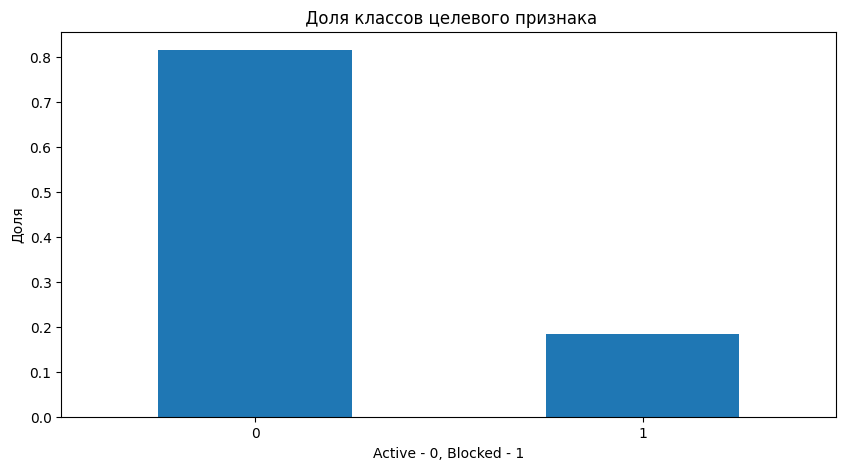

In [53]:
disbalance = df['blocked'].value_counts(normalize = True)
print(disbalance)
plt.figure(figsize=(10, 5))
disbalance.plot(kind='bar')
plt.xlabel('Active - 0, Blocked - 1')
plt.ylabel('Доля')
plt.title(' Доля классов целевого признака')
plt.xticks(rotation=0)
plt.show()

**Целевой класс (выявленные недобросовестные репетиторы)** составляет 18.4% от общего количества репетиторов. Классы не сбалансированы. Это значит, что при обучении модели перевес будет в сторону более многочисленного класса - 0. Нашей же целью является выявление класса 1 - тех репетиторов, которые потенциально могут обманывать платформу.

При выборе целевой метрики качества нужно учитывать несбалансированность классов - приоритет следует отдать метрикам менее чувствительным к дисбалансу, например, **precision и recall**, которые, в отличие от **accuracy**, не зависят от соотношения классов, а также **ROC-AUC**.

Также можно установить балансировку классов с помощью параметра *class_weight*, который имеется в большинстве моделей. *Upsampling* не используем, так как у нас не будет валидационной выборки, а это значит, что при кросс-валидации возможна утечка данных.

#### Построим диаграммы размаха для выявления выбросов в данных

Рассмотрим столбец *days_from_order_to_lesson* (сколько прошло дней от заявки до урока)

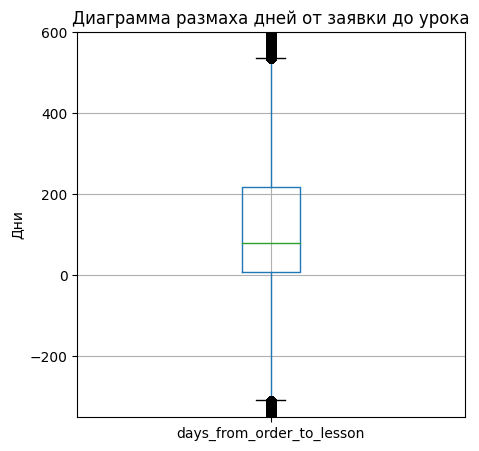

In [54]:
plt.figure(figsize=(5,5))
df.boxplot(column=['days_from_order_to_lesson'])
plt.ylim(-350, 600)
plt.title('Диаграмма размаха дней от заявки до урока')
plt.ylabel('Дни')
plt.show()

In [55]:
df['days_from_order_to_lesson'].value_counts()

days_from_order_to_lesson
 1      22206
 0      21635
 2      19637
 3      18776
 4      17632
        ...  
-785        3
-789        3
-792        3
 882        1
 878        1
Name: count, Length: 1674, dtype: int64

Видим что в среднем от заявки до урока проходит около 100 дней. При этом очень много заявок, где есть отрицательные значения, то есть сначала провели занятие, а потом была заявка. Скорее всего это ошибка при выгрузке либо учитель не поставил нужную отметку в сервисе

Рассмотрим столбцы *teacher_reg*, *teacher_age*, *teaching experience*

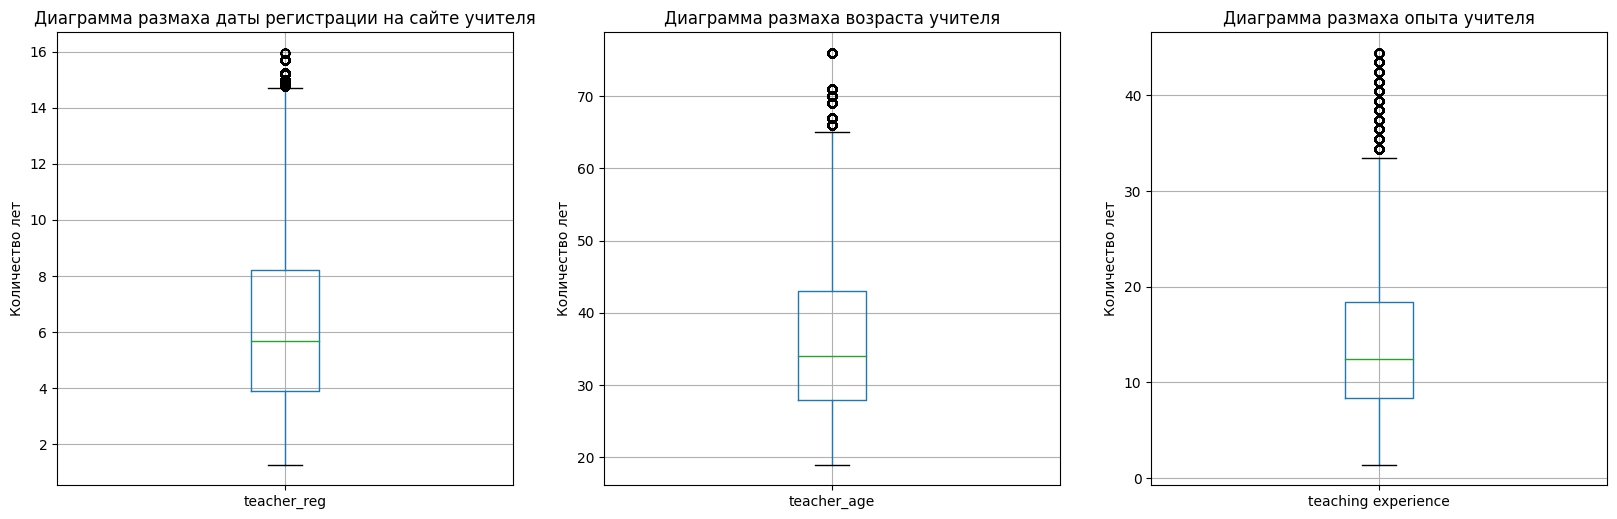

In [56]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 3, 1)
df.boxplot(column=['teacher_reg'])
plt.title('Диаграмма размаха даты регистрации на сайте учителя')
plt.ylabel('Количество лет')

plt.subplot(3, 3, 2)
df.boxplot(column=['teacher_age'])
plt.title('Диаграмма размаха возраста учителя')
plt.ylabel('Количество лет')

plt.subplot(3, 3, 3)
df.boxplot(column=['teaching experience'])
plt.title('Диаграмма размаха опыта учителя')
plt.ylabel('Количество лет')

plt.show()

Рассмотрим столбец *time_from_to* (разница между началом и концом занятия)

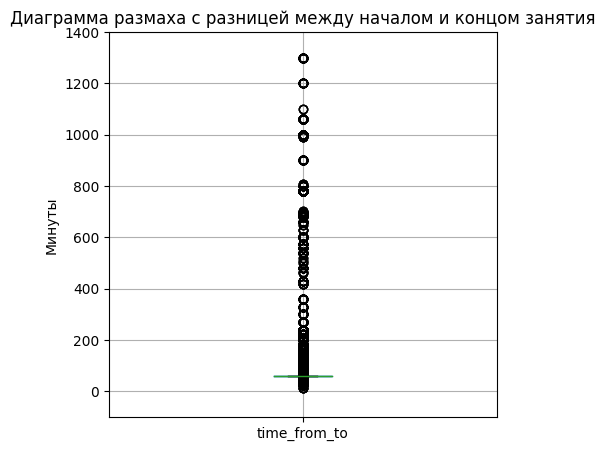

In [57]:
plt.figure(figsize=(5,5))
df.boxplot(column=['time_from_to'])
plt.ylim(-100, 1400)
plt.title('Диаграмма размаха с разницей между началом и концом занятия')
plt.ylabel('Минуты')
plt.show()

В среднем занятия идут около 1 часа, но есть и аномальные значения, когда занятия идут по 1200 минут.

#### Создадим новые признаки

**Рассмотрим случай, когда ученик не отмечен как завершенный, а оплат нет (значения 6 и 13 говорят о факте оплаты заявки).**

In [58]:
df['is_active'].unique()

array([0., 1.])

In [59]:
df['status_id'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16])

In [60]:
df['amount_paid'].sort_values().unique()

array([  200. ,   250. ,   300. ,   350. ,   400. ,   450. ,   475. ,
         500. ,   550. ,   600. ,   650. ,   700. ,   712. ,   712.5,
         713. ,   750. ,   800. ,   850. ,   875. ,   900. ,   950. ,
        1000. ,  1100. ,  1150. ,  1200. ,  1250. ,  1300. ,  1350. ,
        1400. ,  1500. ,  1600. ,  1700. ,  1800. ,  1875. ,  1900. ,
        1950. ,  2000. ,  2200. ,  2250. ,  2290. ,  2300. ,  2400. ,
        2500. ,  2550. ,  2600. ,  2700. ,  2800. ,  3000. ,  3300. ,
        3500. ,  3600. ,  3700. ,  3750. ,  4000. ,  4500. ,  5000. ,
        5250. ,  6000. ,  8000. , 18000. , 24000. ,     nan])

Заполним пропуски в amount_paid (98% пропусков). Предположим что в момент выгрузки данных уроки не были оплачены

In [61]:
df['amount_paid'] = df['amount_paid'].fillna(0)

In [62]:
def status(row):
    if row['is_active'] == 1 and (row['status_id'] == 6 or row['status_id'] == 13) and row['amount_paid'] == 0:
        return 1 # Не заплатил
    else: 
        return 0 # Заплатил

In [63]:
df['pay_status'] = df.apply(status, axis=1)

In [64]:
df['pay_status'].value_counts()

pay_status
0    2235125
1     430931
Name: count, dtype: int64

In [65]:
df_pay = pd.DataFrame(df.groupby('teacher_id')['pay_status'].sum()).reset_index()
df_pay

,teacher_id,pay_status
0,458,0
1,1009,6
2,2536,1827
3,2791,1745
4,3619,8
...,...,...
1213,276152,184
1214,276219,924
1215,276252,438
1216,276377,6


In [66]:
def status(row):
    if row['pay_status'] == 0:
        return 0
    else: 
        return 1

In [67]:
df_pay['paid_status'] = df_pay.apply(status, axis=1)

In [68]:
df_pay = df_pay.drop(['pay_status'], axis=1)
df_pay

,teacher_id,paid_status
0,458,0
1,1009,1
2,2536,1
3,2791,1
4,3619,1
...,...,...
1213,276152,1
1214,276219,1
1215,276252,1
1216,276377,1


In [69]:
df_pay['paid_status'].value_counts()

paid_status
1    1089
0     129
Name: count, dtype: int64

**Рассмотрим случай с низкой ценой урока (ниже 500 - подозрительно).**

In [70]:
def cost(row):
    if row['lesson_cost'] < 500:
        return 1 # Низкая цена
    else: 
        return 0 # Нормальная цена

In [71]:
df['cost_status'] = df.apply(cost, axis=1)

In [72]:
df['cost_status'].value_counts()

cost_status
0    2548922
1     117134
Name: count, dtype: int64

In [73]:
df_cost = pd.DataFrame(df.groupby('teacher_id')['cost_status'].sum()).reset_index()
df_cost

,teacher_id,cost_status
0,458,0
1,1009,0
2,2536,0
3,2791,0
4,3619,0
...,...,...
1213,276152,0
1214,276219,4056
1215,276252,0
1216,276377,0


In [74]:
def status(row):
    if row['cost_status'] == 0:
        return 0
    else: 
        return 1

In [75]:
df_cost['low_cost_status'] = df_cost.apply(status, axis=1)

In [76]:
df_cost = df_cost.drop(['cost_status'], axis=1)
df_cost

,teacher_id,low_cost_status
0,458,0
1,1009,0
2,2536,0
3,2791,0
4,3619,0
...,...,...
1213,276152,0
1214,276219,1
1215,276252,0
1216,276377,0


In [77]:
df_cost['low_cost_status'].value_counts()

low_cost_status
0    1114
1     104
Name: count, dtype: int64

**Рассмотрим случай, когда статус заявки - договорились о занятиях (status в orders = 9), оплат нет более недели**

In [78]:
def no_week_pay(row):
    if row['days_after_lesson'] > 7 and row['status_id'] == 9 and row['amount_paid'] == 0:
        return 1 # Не получили денег, плохой учитель
    else: 
        return 0 # Все ок, деньги получены

In [79]:
df['no_week_pay'] = df.apply(no_week_pay, axis=1)

In [80]:
df['no_week_pay'].value_counts()

no_week_pay
0    2665906
1        150
Name: count, dtype: int64

In [81]:
df.head()

,teacher_id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration_merged_teachers,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num,date_update,subject_id__merged,price,price_external,price_remote,id_lesson_course,client_id,order_id,lesson_place__merged,lesson_price__merged,is_active,lesson_duration_merged_lessons,date_updated,suspend_till_date,id_lessons,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay__merged,amount_paid,id,order_date,subject_id_orders,purpose,lesson_price_orders,lesson_duration,lesson_place_orders,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay_orders,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers,days_from_order_to_lesson,teacher_age,teaching experience,teacher_reg,time_from_to,days_after_lesson,pay_status,cost_status,no_week_pay
10,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16,2017-09-01,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,9,1700,0,1700,1014712.0,975583.0,2148007.0,4.0,1300.0,0.0,60.0,2022-08-25 20:48:47.417,1800-01-01,2655805.0,1014712.0,2022-08-26,0 days 20:00:00,0 days 21:00:00,NaN,0.0,1300.0,1300.0,2148007,2022-08-25 19:35:51.887,8.0,"Разделы: школьный курс, алгебра, геометрия.\n...",1500,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-08-25 19:59:30.957,198013.0,6,None,NaN,0,10,2022-08-26,NaN,12.0,2,1000,3,0,0,4,0,0,35,0,0,23,NaN,NaN,NaN,None,NaT,1,0,26,6.42,3.82,60,56,0,0,0
11,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16,2017-09-01,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,8,1700,0,1700,1014712.0,975583.0,2148007.0,4.0,1300.0,0.0,60.0,2022-08-25 20:48:47.417,1800-01-01,2655805.0,1014712.0,2022-08-26,0 days 20:00:00,0 days 21:00:00,NaN,0.0,1300.0,1300.0,2148007,2022-08-25 19:35:51.887,8.0,"Разделы: школьный курс, алгебра, геометрия.\n...",1500,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-08-25 19:59:30.957,198013.0,6,None,NaN,0,10,2022-08-26,NaN,12.0,2,1000,3,0,0,4,0,0,35,0,0,23,NaN,NaN,NaN,None,NaT,1,0,26,6.42,3.82,60,56,0,0,0
12,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16,2017-09-01,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,9,1700,0,1700,1016021.0,976426.0,2150543.0,4.0,1000.0,1.0,60.0,2023-05-24 19:54:27.013,2023-09-01,2658003.0,1016021.0,2022-09-05,0 days 19:30:00,0 days 20:30:00,NaN,0.0,1000.0,1000.0,2150282,2022-08-27 14:07:13.853,8.0,Разделы: школьный курс.\nДополнения: ОГЭ (ГИА...,1000,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-08-27 15:40:57.173,256100.0,16,Тестовая группа : SplitTestA\n?Статус дозаполн...,NaN,0,10,NaT,NaN,10.0,5,0,1,0,0,4,0,0,30,0,0,16,NaN,13.0,NaN,0,NaT,1,8,26,6.42,3.82,60,46,0,0,0
13,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16,2017-09-01,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,9,1700,0,1700,1016021.0,976426.0,2150543.0,4.0,1000.0,1.0,60.0,2023-05-24 19:54:27.013,2023-09-01,2658003.0,1016021.0,2022-09-05,0 days 19:30:00,0 days 20:30:00,NaN,0.0,1000.0,1000.0,2150543,2022-08-27 17:05:56.213,8.0,Разделы: школьный курс.\nДополнения: ОГЭ (ГИА...,1000,60,None,NaN,Место проведения занят

In [82]:
df_no_week_pay = pd.DataFrame(df.groupby('teacher_id')['no_week_pay'].sum()).reset_index()
df_no_week_pay

,teacher_id,no_week_pay
0,458,0
1,1009,0
2,2536,0
3,2791,0
4,3619,0
...,...,...
1213,276152,0
1214,276219,0
1215,276252,0
1216,276377,0


In [83]:
def status(row):
    if row['no_week_pay'] == 0:
        return 0
    else: 
        return 1

In [84]:
df_no_week_pay['no_week_pay_status'] = df_no_week_pay.apply(status, axis=1)

In [85]:
df_no_week_pay = df_no_week_pay.drop(['no_week_pay'], axis=1)
df_no_week_pay

,teacher_id,no_week_pay_status
0,458,0
1,1009,0
2,2536,0
3,2791,0
4,3619,0
...,...,...
1213,276152,0
1214,276219,0
1215,276252,0
1216,276377,0


In [86]:
df_no_week_pay['no_week_pay_status'].value_counts()

no_week_pay_status
0    1200
1      18
Name: count, dtype: int64

**Рассмотрим случай, когда идет разная стоимость уроков с одним учеником**

In [87]:
df_diff_cost = df.pivot_table(index=['teacher_id', 'client_id'], values='amount_to_pay__merged', aggfunc=['min', 'max']).reset_index()
df_diff_cost = df_diff_cost.reset_index().droplevel(1, axis=1)
df_diff_cost.columns=['ind', 'teacher_id','client_id', 'amount_to_pay_min', 'amount_to_pay_max']
df_diff_cost.sort_values(by='teacher_id').reset_index(drop=True).head(10)

,ind,teacher_id,client_id,amount_to_pay_min,amount_to_pay_max
0,0,458,1180107.0,1800.0,1800.0
1,15,1009,1191410.0,2500.0,2500.0
2,14,1009,1166067.0,2500.0,2500.0
3,13,1009,1022109.0,1000.0,1000.0
4,11,1009,1010994.0,1500.0,1500.0
5,10,1009,998267.0,1500.0,1500.0
6,9,1009,996193.0,2000.0,2000.0
7,8,1009,962450.0,1500.0,1500.0
8,12,1009,1015857.0,1500.0,1500.0
9,6,1009,955335.0,1500.0,1500.0


In [88]:
def diff_cost(row):
    if (row['amount_to_pay_min'] - row['amount_to_pay_max']) != 0:
        return 1
    else: 
        return 0

In [89]:
df_diff_cost['diff_cost'] = df_diff_cost.apply(diff_cost, axis=1)
df_diff_cost

,ind,teacher_id,client_id,amount_to_pay_min,amount_to_pay_max,diff_cost
0,0,458,1180107.0,1800.0,1800.0,0
1,1,1009,237777.0,2000.0,2000.0,0
2,2,1009,430712.0,1500.0,1500.0,0
3,3,1009,702379.0,1500.0,1500.0,0
4,4,1009,850968.0,1500.0,1500.0,0
...,...,...,...,...,...,...
13016,13016,276252,1020095.0,645.0,645.0,0
13017,13017,276252,1023910.0,1000.0,1000.0,0
13018,13018,276252,1119325.0,750.0,1500.0,1
13019,13019,276252,1182130.0,1500.0,1500.0,0


In [90]:
df_diff_cost['diff_cost'].value_counts()

diff_cost
0    11370
1     1651
Name: count, dtype: int64

In [91]:
df_diff_cost_status = pd.DataFrame(df_diff_cost.groupby('teacher_id')['diff_cost'].sum()).reset_index()
df_diff_cost_status

,teacher_id,diff_cost
0,458,0
1,1009,0
2,2536,1
3,2791,4
4,3619,0
...,...,...
1195,276116,0
1196,276152,2
1197,276219,0
1198,276252,1


In [92]:
def status(row):
    if row['diff_cost'] == 0:
        return 0
    else: 
        return 1

In [93]:
df_diff_cost_status['diff_cost_status'] = df_diff_cost_status.apply(status, axis=1)

In [94]:
df_diff_cost_status = df_diff_cost_status.drop(['diff_cost'], axis=1)
df_diff_cost_status

,teacher_id,diff_cost_status
0,458,0
1,1009,0
2,2536,1
3,2791,1
4,3619,0
...,...,...
1195,276116,0
1196,276152,1
1197,276219,0
1198,276252,1


In [95]:
df_diff_cost_status['diff_cost_status'].value_counts()

diff_cost_status
0    613
1    587
Name: count, dtype: int64

**Рассмотрим случай, когда продолжительность урока не совпадает с фактически проведенным временем урока**

In [96]:
def duration(row):
    if ((row['time_from_to']-30) <= row['lesson_duration']) and (row['lesson_duration'] <= (row['time_from_to']+30)):
        return 0 # Время урока равно фактически проведенному времени +-30 минут
    else: 
        return 1 # Время урока и фактически проведенное время не совпадают

In [97]:
df['lesson_duration_status'] = df.apply(duration, axis=1)

In [98]:
df['lesson_duration_status'].value_counts()

lesson_duration_status
0    2560769
1     105287
Name: count, dtype: int64

In [99]:
df.query('lesson_duration_status == 1').head()

,teacher_id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration_merged_teachers,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num,date_update,subject_id__merged,price,price_external,price_remote,id_lesson_course,client_id,order_id,lesson_place__merged,lesson_price__merged,is_active,lesson_duration_merged_lessons,date_updated,suspend_till_date,id_lessons,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay__merged,amount_paid,id,order_date,subject_id_orders,purpose,lesson_price_orders,lesson_duration,lesson_place_orders,home_metro_id,add_info,start_date,working_teacher_id,status_id,comments,prefered_teacher_id,amount_to_pay_orders,planned_lesson_number,first_lesson_date,creator_id,pupil_category_new_id,lessons_per_week,minimal_price,teacher_sex,teacher_experience_from,teacher_experience_to,lesson_place_new,pupil_knowledgelvl,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers,days_from_order_to_lesson,teacher_age,teaching experience,teacher_reg,time_from_to,days_after_lesson,pay_status,cost_status,no_week_pay,lesson_duration_status
941,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16,2017-09-01,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,9,1700,0,1700,1030579.0,985677.0,2177454.0,4.0,1000.0,1.0,60.0,2023-06-28 13:04:29.347,2023-09-01,3531837.0,1030579.0,2023-04-07,0 days 18:45:00,0 days 20:45:00,NaN,0.0,2400.0,0.0,2177454,2022-09-07 16:40:11.277,9.0,+ МАТЕМАТИКА\nРазделы: школьный курс.\nДополн...,1500,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-09-07 18:30:49.137,198013.0,6,Тестовая группа : SplitTestB,NaN,0,10,2022-09-09,NaN,10.0,5,0,3,0,0,4,0,0,0,0,0,16,NaN,NaN,NaN,0,NaT,1,211,26,6.42,3.82,120,-168,1,0,0,1
1077,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16,2017-09-01,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,8,1700,0,1700,1030579.0,985677.0,2177454.0,4.0,1000.0,1.0,60.0,2023-06-28 13:04:29.347,2023-09-01,3531837.0,1030579.0,2023-04-07,0 days 18:45:00,0 days 20:45:00,NaN,0.0,2400.0,0.0,2177454,2022-09-07 16:40:11.277,9.0,+ МАТЕМАТИКА\nРазделы: школьный курс.\nДополн...,1500,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-09-07 18:30:49.137,198013.0,6,Тестовая группа : SplitTestB,NaN,0,10,2022-09-09,NaN,10.0,5,0,3,0,0,4,0,0,0,0,0,16,NaN,NaN,NaN,0,NaT,1,211,26,6.42,3.82,120,-168,1,0,0,1
5196,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16,2017-09-01,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,9,1700,0,1700,1006848.0,969845.0,2132761.0,4.0,1200.0,1.0,60.0,2022-08-15 16:21:40.160,1800-01-01,3690402.0,1006848.0,2023-06-19,0 days 14:00:00,0 days 16:00:00,NaN,0.0,3200.0,0.0,2132761,2022-08-12 22:40:15.437,8.0,Разделы: школьный курс\nКатегория ученика: шк...,2000,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-08-14 13:22:04.220,198013.0,6,None,NaN,0,10,2022-08-20,NaN,9.0,2,0,3,1,0,4,0,25,50,0,0,23,NaN,NaN,NaN,0,NaT,1,310,26,6.42,3.82,120,-241,1,0,0,1
5197,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16,2017-09-01,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,9,1700,0,1700,1006848.0,969845.0,2132761.0,4.0,1200.0,1.0,60.0,2022-08-15 16:21:40.160,1800-01-01,3690402.0,1006848.0,2023-06-19,0 days 14:00:00,0 days 16:00:00,NaN,0.0,3200.0,0.0,2133798,2022-08-14 13:22:58.837,8.0,Разделы: школьный курс\nКатегория ученика: шк...,1500,60,No

In [100]:
df_lesson_duration = pd.DataFrame(df.groupby('teacher_id')['lesson_duration_status'].sum()).reset_index()
df_lesson_duration

,teacher_id,lesson_duration_status
0,458,0
1,1009,0
2,2536,75
3,2791,0
4,3619,0
...,...,...
1213,276152,0
1214,276219,48
1215,276252,0
1216,276377,0


In [101]:
def duration_status(row):
    if row['lesson_duration_status'] == 0:
        return 0
    else: 
        return 1

In [102]:
df_lesson_duration['duration_status'] = df_lesson_duration.apply(duration_status, axis=1)

In [103]:
df_lesson_duration = df_lesson_duration.drop(['lesson_duration_status'], axis=1)
df_lesson_duration

,teacher_id,duration_status
0,458,0
1,1009,0
2,2536,1
3,2791,0
4,3619,0
...,...,...
1213,276152,0
1214,276219,1
1215,276252,0
1216,276377,0


In [104]:
df_lesson_duration['duration_status'].value_counts()

duration_status
0    633
1    585
Name: count, dtype: int64

**Рассмотрим несоответствие цены в заявке и у ученика**

In [105]:
def lesson_price(row):
    if row['lesson_price__merged'] == row['lesson_price_orders']:
        return 0 # цена равна
    else: 
        return 1 # Цены в заявке и у ученика по факту разные

In [106]:
df['lesson_price_status'] = df.apply(lesson_price, axis=1)

In [107]:
df['lesson_price_status'].value_counts()

lesson_price_status
1    1929664
0     736392
Name: count, dtype: int64

In [108]:
df_lesson_price = pd.DataFrame(df.groupby('teacher_id')['lesson_price_status'].sum()).reset_index()
df_lesson_price

,teacher_id,lesson_price_status
0,458,22
1,1009,393
2,2536,4371
3,2791,5120
4,3619,40
...,...,...
1213,276152,184
1214,276219,2538
1215,276252,789
1216,276377,45


In [109]:
df_lesson_price['lesson_price_status'].median()

379.5

In [110]:
def price_status(row):
    if row['lesson_price_status'] <= 10:
        return 0
    else: 
        return 1

In [111]:
df_lesson_price['price_status'] = df_lesson_price.apply(price_status, axis=1)

In [112]:
df_lesson_price = df_lesson_price.drop(['lesson_price_status'], axis=1)
df_lesson_price

,teacher_id,price_status
0,458,1
1,1009,1
2,2536,1
3,2791,1
4,3619,1
...,...,...
1213,276152,1
1214,276219,1
1215,276252,1
1216,276377,1


In [113]:
df_lesson_price['price_status'].value_counts()

price_status
1    1140
0      78
Name: count, dtype: int64

**Соберем все признаки, полученные от дат, в отдельной таблице**

In [114]:
df_date = df[['teacher_id', 'teacher_age', 'teaching experience', 'teacher_reg']]
df_date

,teacher_id,teacher_age,teaching experience,teacher_reg
10,198013,26,6.42,3.82
11,198013,26,6.42,3.82
12,198013,26,6.42,3.82
13,198013,26,6.42,3.82
14,198013,26,6.42,3.82
...,...,...,...,...
3647787,142631,28,7.42,5.73
3647788,142631,28,7.42,5.73
3647789,142631,28,7.42,5.73
3647790,142631,28,7.42,5.73


In [115]:
df_date = df_date.drop_duplicates()
df_date.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1218 entries, 10 to 3646830
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   teacher_id           1218 non-null   int64  
 1   teacher_age          1218 non-null   int64  
 2   teaching experience  1218 non-null   float64
 3   teacher_reg          1218 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 47.6 KB


#### Соберем датасет из признаков для обучения моделей

In [116]:
df_new = df_merged_teachers.merge(
         df_pay, on='teacher_id').merge(
         df_cost, on='teacher_id').merge(
         df_no_week_pay, on='teacher_id').merge(
         df_diff_cost_status, on='teacher_id').merge(
         df_lesson_duration, on='teacher_id').merge(
         df_date, on='teacher_id').merge(
         df_lesson_price, on='teacher_id')
df_new = df_new.set_index('teacher_id')
df_new.head()

,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num,date_update,subject_id,price,price_external,price_remote,paid_status,low_cost_status,no_week_pay_status,diff_cost_status,duration_status,teacher_age,teaching experience,teacher_reg,price_status
teacher_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16 00:00:00.000,2017-09-01 00:00:00.000,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,9,1700,0,1700,1,0,0,1,1,26,6.42,3.82,1
198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,2020-04-04 10:22:23.207,1997-04-16 00:00:00.000,2017-09-01 00:00:00.000,0.0,60.0,800.0,1.0,2022-10-21 16:44:49.877,NaN,0.0,2.0,1.0,1.0,10.0,2020-04-06 16:53:51.313,8,1700,0,1700,1,0,0,1,1,26,6.42,3.82,1
153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0,2018-10-19 20:23:24.157,1968-03-10 00:00:00.000,1985-09-01 00:00:00.000,0.0,60.0,600.0,1.0,2022-10-22 16:16:44.800,NaN,0.0,13.0,2.0,1.0,26.0,2018-11-14 18:54:44.113,18,0,0,1200,1,0,0,1,1,55,38.44,5.28,1
42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0,2012-09-20 20:42:52.000,1965-04-20 00:00:00.000,2002-09-01 00:00:00.000,0.0,60.0,2500.0,1.0,2022-10-22 21:21:47.523,NaN,0.0,2.0,2.0,1.0,64.0,2012-09-20 20:42:52.390,3,0,0,2500,1,0,0,0,0,58,21.43,11.37,1
127280,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0,2017-09-06 16:51:20.000,1986-05-07 00:00:00.000,2005-09-01 00:00:00.000,0.0,60.0,1500.0,1.0,2022-03-17 22:50:23.267,NaN,0.0,1.0,2.0,1.0,10.0,2017-09-06 16:51:20.087,2,2500,3000,2500,1,0,0,1,0,37,18.43,6.40,1


In [117]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2276 entries, 198013 to 142631
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lessons_delivered         2276 non-null   float64
 1   mean_lesson_price         2276 non-null   float64
 2   lessons_given             2276 non-null   float64
 3   lessons_started_fraction  2276 non-null   float64
 4   lessons_per_pupil         2276 non-null   float64
 5   money_recieved            2276 non-null   float64
 6   blocked                   2276 non-null   int64  
 7   reg_date                  2276 non-null   object 
 8   birth_date                2276 non-null   object 
 9   teaching_start_date       2276 non-null   object 
 10  is_email_confirmed        2276 non-null   float64
 11  lesson_duration           2276 non-null   float64
 12  lesson_cost               2276 non-null   float64
 13  is_display                2276 non-null   float64
 14  last_v

In [118]:
pd.DataFrame(round(df_new.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
lessons_delivered,0.000000
mean_lesson_price,0.000000
lessons_given,0.000000
lessons_started_fraction,0.000000
lessons_per_pupil,0.000000
money_recieved,0.000000
blocked,0.000000
reg_date,0.000000
birth_date,0.000000
teaching_start_date,0.000000


In [119]:
# Удалим лишние столбцы, так как их значение мы выделили в других признаках
df_new = df_new.drop(
    ['is_pupils_needed', 
     'reg_date',
     'birth_date', 
     'teaching_start_date', 
     'last_visited', 
     'orders_allowed',
     'date_update',
     'subject_id'], axis=1)

In [120]:
print('Количество дубликатов:', df_new.duplicated().sum())

Количество дубликатов: 752


In [121]:
# Удалим дубликаты
df_new = df_new.drop_duplicates()
print('Количество дубликатов:', df_new.duplicated().sum())

Количество дубликатов: 0


In [122]:
df_new.head()

,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,is_email_confirmed,lesson_duration,lesson_cost,is_display,is_cell_phone_confirmed,area_id,sex,review_num,price,price_external,price_remote,paid_status,low_cost_status,no_week_pay_status,diff_cost_status,duration_status,teacher_age,teaching experience,teacher_reg,price_status
teacher_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,0.0,60.0,800.0,1.0,0.0,2.0,1.0,10.0,1700,0,1700,1,0,0,1,1,26,6.42,3.82,1
153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0,0.0,60.0,600.0,1.0,0.0,13.0,2.0,26.0,0,0,1200,1,0,0,1,1,55,38.44,5.28,1
42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0,0.0,60.0,2500.0,1.0,0.0,2.0,2.0,64.0,0,0,2500,1,0,0,0,0,58,21.43,11.37,1
127280,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0,0.0,60.0,1500.0,1.0,0.0,1.0,2.0,10.0,2500,3000,2500,1,0,0,1,0,37,18.43,6.40,1
88923,1312.0,1776.096998,866.0,0.681818,57.733333,1538100.0,0,0.0,60.0,2200.0,1.0,0.0,1.0,1.0,48.0,3500,0,2500,1,0,0,1,0,28,10.42,8.47,1


In [123]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1524 entries, 198013 to 142631
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lessons_delivered         1524 non-null   float64
 1   mean_lesson_price         1524 non-null   float64
 2   lessons_given             1524 non-null   float64
 3   lessons_started_fraction  1524 non-null   float64
 4   lessons_per_pupil         1524 non-null   float64
 5   money_recieved            1524 non-null   float64
 6   blocked                   1524 non-null   int64  
 7   is_email_confirmed        1524 non-null   float64
 8   lesson_duration           1524 non-null   float64
 9   lesson_cost               1524 non-null   float64
 10  is_display                1524 non-null   float64
 11  is_cell_phone_confirmed   1524 non-null   float64
 12  area_id                   1524 non-null   float64
 13  sex                       1524 non-null   float64
 14  review

Подготовили данные для дальнейшего исследования:

- Удалили дубликаты
- Добавили новые признаки:
  - paid_status
  - low_cost_status
  - no_week_pay_status
  - diff_cost_status
  - duration_status
  - teacher_age
  - teaching experience
  - teacher_reg
  - price_status

#### Проверим на мультиколлинеарность

Далее проведем более подробный корреляционный анализ, в том числе категориальных признаков с помощью `phik`. Это позволит уменьшить количество признаков для обучения за счет удаления признаков с мультиколлинеарностью. 

Мультиколлинеарность — корреляция независимых переменных, которая затрудняет оценку и анализ общего результата.

В машинном обучении мультиколлинеарность может стать причиной переобучаемости модели, что приведет к неверному результату. Кроме того, избыточные коэффициенты увеличивают сложность модели машинного обучения, а значит, время ее тренировки возрастает.

In [124]:
df_phik = (df_new.phik_matrix()).round(2)

interval columns not set, guessing: ['lessons_delivered', 'mean_lesson_price', 'lessons_given', 'lessons_started_fraction', 'lessons_per_pupil', 'money_recieved', 'blocked', 'is_email_confirmed', 'lesson_duration', 'lesson_cost', 'is_display', 'is_cell_phone_confirmed', 'area_id', 'sex', 'review_num', 'price', 'price_external', 'price_remote', 'paid_status', 'low_cost_status', 'no_week_pay_status', 'diff_cost_status', 'duration_status', 'teacher_age', 'teaching experience', 'teacher_reg', 'price_status']


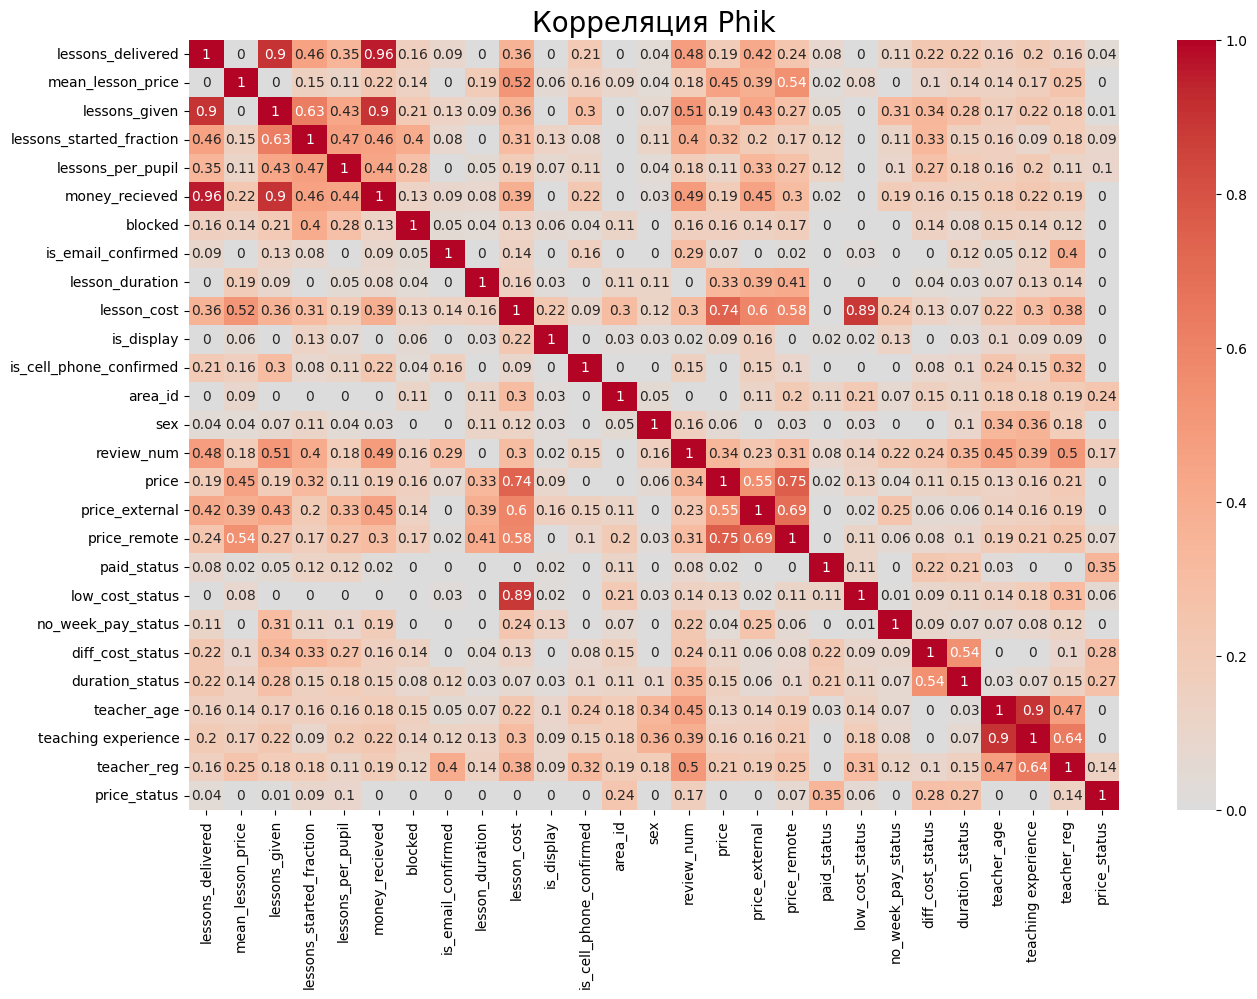

In [125]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df_phik, cmap='coolwarm', center=0, annot=True)
plt.title("Корреляция Phik", fontsize =20)
plt.show()

Если признаки коррелируют между собой более, чем на 0.7, то один из признаков убираем, чтобы не было мультиколлинеарности. Также удалим признаки, которые никак не коррелируют с целевым признаком.

In [126]:
# оставляем в датафрейме выбранные признаки
df_corr = df_new.copy()
df_corr = df_new[['money_recieved', 
             'mean_lesson_price',
             'lessons_started_fraction', 
             'lessons_per_pupil', 
             'lesson_duration',
             'lesson_cost', 
             'area_id', 
             'review_num', 
             'price', 
             'price_external', 
             'price_remote',
             'diff_cost_status',
             'duration_status',
             'teaching experience',
             'teacher_reg',
             'blocked']].reset_index(drop=True)

In [127]:
df_corr.head()

,money_recieved,mean_lesson_price,lessons_started_fraction,lessons_per_pupil,lesson_duration,lesson_cost,area_id,review_num,price,price_external,price_remote,diff_cost_status,duration_status,teaching experience,teacher_reg,blocked
0,602300.0,1284.221748,0.666667,78.166667,60.0,800.0,2.0,10.0,1700,0,1700,1,1,6.42,3.82,0
1,956580.0,884.085028,0.358974,77.285714,60.0,600.0,13.0,26.0,0,0,1200,1,1,38.44,5.28,0
2,460000.0,2500.000000,0.142857,61.333333,60.0,2500.0,2.0,64.0,0,0,2500,0,0,21.43,11.37,0
3,682200.0,1879.338843,0.150000,60.500000,60.0,1500.0,1.0,10.0,2500,3000,2500,1,0,18.43,6.40,0
4,1538100.0,1776.096998,0.681818,57.733333,60.0,2200.0,1.0,48.0,3500,0,2500,1,0,10.42,8.47,0


In [128]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1524 entries, 0 to 1523
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   money_recieved            1524 non-null   float64
 1   mean_lesson_price         1524 non-null   float64
 2   lessons_started_fraction  1524 non-null   float64
 3   lessons_per_pupil         1524 non-null   float64
 4   lesson_duration           1524 non-null   float64
 5   lesson_cost               1524 non-null   float64
 6   area_id                   1524 non-null   float64
 7   review_num                1524 non-null   float64
 8   price                     1524 non-null   int64  
 9   price_external            1524 non-null   int64  
 10  price_remote              1524 non-null   int64  
 11  diff_cost_status          1524 non-null   int64  
 12  duration_status           1524 non-null   int64  
 13  teaching experience       1524 non-null   float64
 14  teacher_

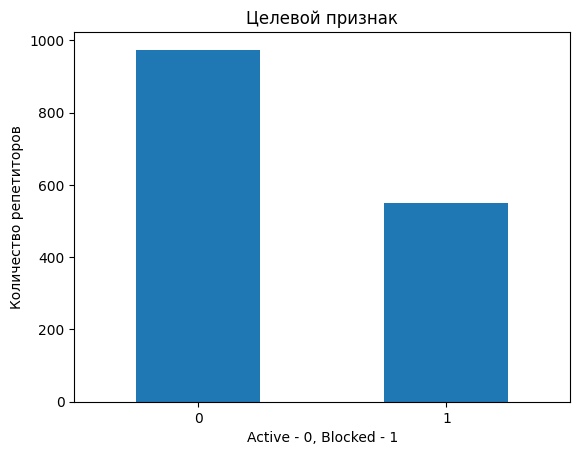

In [129]:
df_corr['blocked'].value_counts().plot.bar()
plt.title("Целевой признак")
plt.ylabel('Количество репетиторов')
plt.xlabel('Active - 0, Blocked - 1')
plt.xticks(rotation=0)
plt.show()

## Подготовка данных для построения модели

### Деление данных на выборки

In [136]:
# отделяем целевой признак

features = df_corr.drop(['blocked'], axis=1)
target = df_corr['blocked']

Делим на тренировочную и тестовую выборки (со стратификацией). Стратификация - разбиение на трейн и тест, сохраняющее соотношение классов, представленное в исходном датасете.

In [138]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, stratify=target, random_state=RANDOM_STATE, shuffle=True)

print('Размер тренировочной выборки (признаки):', features_train.shape)
print('Размер тестовой выборки (признаки):', features_test.shape)
print('Размер тренировочной выборки (целевой признак):', target_train.shape)
print('Размер тестовой выборки (целевой признак):', target_test.shape)

Размер тренировочной выборки (признаки): (1143, 15)
Размер тестовой выборки (признаки): (381, 15)
Размер тренировочной выборки (целевой признак): (1143,)
Размер тестовой выборки (целевой признак): (381,)


In [139]:
features_train.head()

,money_recieved,mean_lesson_price,lessons_started_fraction,lessons_per_pupil,lesson_duration,lesson_cost,area_id,review_num,price,price_external,price_remote,diff_cost_status,duration_status,teaching experience,teacher_reg
724,415100.0,1456.491228,0.192090,8.382353,60.0,1500.0,1.0,20.0,0,2000,1500,1,1,15.42,11.12
255,1017090.0,1922.665406,0.329545,18.241379,60.0,2000.0,1.0,16.0,2200,0,2200,1,1,9.42,6.80
1490,1500.0,1500.000000,0.200000,1.000000,60.0,1000.0,27.0,4.0,2000,1000,1500,0,0,5.42,3.34
570,691500.0,3324.519231,0.161017,10.947368,60.0,4000.0,1.0,19.0,5000,0,3000,1,1,8.42,3.22
991,21900.0,1368.750000,0.130435,5.333333,60.0,2000.0,1.0,0.0,0,1700,1400,0,0,2.42,1.69


### Кодирование признаков

Закодируем признаки отдельно для логистической регрессии (`LogisticRegression`) и случайного леса (`RandomForestClassifier`):

- для регрессии будем использовать как кодирование категориальных признаков (OneHotEncoder), так и шкалирование (StandardScaler) для количественных признаков;
- для случайного леса шкалирование не требуется, применим только OrdinalEncoder.

Наименования категориальных признаков будем использовать для `CatBoostClassifier`, так как эта модель имеет свой кодировщик для категориальных значений - `cat_features`.

In [140]:
# категориальные признаки (проверка)

oe_features = features_train.select_dtypes(include=['object']).columns.to_list()
oe_features

[]

In [141]:
# численные признаки

num_features = features_train.select_dtypes(exclude=['object']).columns.to_list()
num_features

['money_recieved',
 'mean_lesson_price',
 'lessons_started_fraction',
 'lessons_per_pupil',
 'lesson_duration',
 'lesson_cost',
 'area_id',
 'review_num',
 'price',
 'price_external',
 'price_remote',
 'diff_cost_status',
 'duration_status',
 'teaching experience',
 'teacher_reg']

Создадим трансформер для `LogisticRegression`

In [142]:
col_transformer_LR = make_column_transformer((StandardScaler(), num_features))

### Построение моделей и оценка их качества

Будут подобраны параметры и построены следующие модели:

- LogisticRegression;
- RandomForestClassifier;
- CatBoostClassifier.

В завершении будет выбрана модель с наилучшими показателями целевой метрики *F1*.

Напишем функцию для подбора гиперпараметров

In [143]:
def best_hyper_model(model, 
                     parameters_m, 
                     transform, 
                     features=features_train, 
                     target=target_train):
    
    steps = [('transform', transform), ('model', model)]
    model = Pipeline(steps)

    # подбор лучших гиперпараметров модели с учетом метрики F1

    rand_m = RandomizedSearchCV(estimator=model, 
                                param_distributions=parameters_m, 
                                cv=5, 
                                scoring='f1', 
                                n_jobs=-2, 
                                random_state=RANDOM_STATE)
    
    rand_m.fit(features, target)

    best_params = rand_m.best_params_
    print('Гиперпараметры лучшей модели', best_params)
    
    best_model = rand_m.best_estimator_
    
    best_score = rand_m.best_score_
    print('F1 модели', best_score)

    return  best_model, best_params, best_score

#### Первая модель - `Логистическая регрессия (LogisticRegression)`.

In [144]:
parameters_LR  = {'model__class_weight': ['balanced', None], 'model__C' : [10, 100, 1000]}

In [145]:
%%time

model_LR, params_LR, best_score_LR = best_hyper_model(
    LogisticRegression(random_state=RANDOM_STATE),
    parameters_LR,
    col_transformer_LR
)

Гиперпараметры лучшей модели {'model__class_weight': 'balanced', 'model__C': 10}
F1 модели 0.5977720751802469
CPU times: total: 31.2 ms
Wall time: 536 ms


In [146]:
results_LR = []
results_LR.append({'Модель': 'LogisticRegression',
                'Параметры': params_LR,
                'F1': round(best_score_LR, 2)})

pd.DataFrame(results_LR)

,Модель,Параметры,F1
0,LogisticRegression,"{'model__class_weight': 'balanced', 'model__C'...",0.6


#### Вторая модель - `Случайный лес (RandomForestClassifier)`.

In [147]:
parameters_RFC  = {'model__max_depth': [None] + [i for i in range(2, 20)],
                   'model__n_estimators': range(1, 101, 10),
                   'model__class_weight': ['balanced', None]}

In [148]:
%%time

model_RFC, params_RFC, best_score_RFC = best_hyper_model(
    RandomForestClassifier(random_state=RANDOM_STATE),
    parameters_RFC,
    transform=None
)

Гиперпараметры лучшей модели {'model__n_estimators': 61, 'model__max_depth': 8, 'model__class_weight': 'balanced'}
F1 модели 0.6779096764805619
CPU times: total: 188 ms
Wall time: 1.03 s


In [149]:
results_RFC = []
results_RFC.append({'Модель': 'RandomForestClassifier',
                'Параметры': params_RFC,
                'F1': round(best_score_RFC, 2)})

pd.DataFrame(results_RFC)

,Модель,Параметры,F1
0,RandomForestClassifier,"{'model__n_estimators': 61, 'model__max_depth'...",0.68


#### Третья модель - `CatBoostClassifier`.

In [150]:
parameters_CBC  = {'model__iterations': range(1, 101, 10),
                   'model__depth' : range(1, 16, 1),
                   'model__learning_rate' : [0.001, 0.01,0.02,0.03,0.04],
                   'model__loss_function' : ['Logloss', 'MultiClass'],
                   'verbose': [True, False]}

In [151]:
%%time

model_CBC, params_CBC, best_score_CBC = best_hyper_model(
    CatBoostClassifier(random_state=RANDOM_STATE, 
                       auto_class_weights='Balanced'),
    parameters_CBC,
    transform=None
)

[Pipeline] ......... (step 1 of 2) Processing transform, total=   0.0s
0:	learn: 0.6891545	total: 283ms	remaining: 19.8s
1:	learn: 0.6856026	total: 429ms	remaining: 14.8s
2:	learn: 0.6816088	total: 576ms	remaining: 13.1s
3:	learn: 0.6779448	total: 718ms	remaining: 12s
4:	learn: 0.6741451	total: 865ms	remaining: 11.4s
5:	learn: 0.6703019	total: 1.01s	remaining: 11s
6:	learn: 0.6662207	total: 1.15s	remaining: 10.5s
7:	learn: 0.6627094	total: 1.3s	remaining: 10.2s
8:	learn: 0.6592046	total: 1.45s	remaining: 9.96s
9:	learn: 0.6554653	total: 1.59s	remaining: 9.7s
10:	learn: 0.6521309	total: 1.74s	remaining: 9.48s
11:	learn: 0.6487457	total: 1.88s	remaining: 9.25s
12:	learn: 0.6455669	total: 2.02s	remaining: 9.03s
13:	learn: 0.6418021	total: 2.17s	remaining: 8.84s
14:	learn: 0.6384624	total: 2.33s	remaining: 8.71s
15:	learn: 0.6346321	total: 2.33s	remaining: 8.02s
16:	learn: 0.6315859	total: 2.48s	remaining: 7.87s
17:	learn: 0.6285974	total: 2.62s	remaining: 7.71s
18:	learn: 0.6254705	total:

In [152]:
results_CBC = []
results_CBC.append({'Модель': 'CatBoostClassifier',
                'Параметры': params_CBC,
                'F1': round(best_score_CBC, 2)})
pd.set_option('display.max_colwidth', None)
pd.DataFrame(results_CBC)

,Модель,Параметры,F1
0,CatBoostClassifier,"{'verbose': True, 'model__loss_function': 'Logloss', 'model__learning_rate': 0.03, 'model__iterations': 71, 'model__depth': 12}",0.68


Были обучены 3 модели: `LogisticRegression, RandomForestClassifier, CatBoostClassifier`. Соберем все результаты в одну таблицу и выберем наилучшую модель.

In [162]:
pd.DataFrame(
    {'Параметры': [params_LR, params_RFC, params_CBC], 
     'F1': [round(best_score_LR, 2), round(best_score_RFC, 2), round(best_score_CBC, 2)]},
    index=['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier']
)

,Параметры,F1
LogisticRegression,"{'model__class_weight': 'balanced', 'model__C': 10}",0.60
RandomForestClassifier,"{'model__n_estimators': 61, 'model__max_depth': 8, 'model__class_weight': 'balanced'}",0.68
CatBoostClassifier,"{'verbose': True, 'model__loss_function': 'Logloss', 'model__learning_rate': 0.03, 'model__iterations': 71, 'model__depth': 12}",0.68


**Вывод:** Наилучшей по качеству стал алгоритм `CatBoostClassifier`. Выберем его за основу нашей модели обучения и проверим на тестовой выборке.

## Тестирование модели

### Проверим модель на тестовой выборке

In [153]:
prediction_test = model_CBC.predict(features_test)

probabilities_test = model_CBC.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

f1_test = f1_score(target_test, prediction_test)
roc_auc_test = roc_auc_score(target_test, probabilities_one_test)
accuracy_test = accuracy_score(target_test, prediction_test)
recall_test = recall_score(target_test, prediction_test)

print("Результат тестовой метрики F1 для модели CatBoostClassifier:", round(f1_test, 4))
print("Результат тестовой метрики ROC-AUC для модели CatBoostClassifier:", round(roc_auc_test, 4))
print("Результат тестовой метрики Accuracy для модели CatBoostClassifier:", round(accuracy_test, 4))
print("Результат тестовой метрики Recall для модели CatBoostClassifier:", round(recall_test, 4))

Результат тестовой метрики F1 для модели CatBoostClassifier: 0.7066
Результат тестовой метрики ROC-AUC для модели CatBoostClassifier: 0.8427
Результат тестовой метрики Accuracy для модели CatBoostClassifier: 0.7559
Результат тестовой метрики Recall для модели CatBoostClassifier: 0.8116


На тестовой выборке получили следующие значения:

- F1 0.71
- ROC-AUC 0.84
- Accuracy 0.76
- Recall 0.81

При несбалансированных данных оценка **F1** обеспечит лучшую оценку эффективности модели.

**ROC-AUC** можно интерпретировать как показатель модели чьи прогнозы предсказания верны на 84%. Причем AUC не зависит от масштаба - он измеряет, насколько хорошо ранжируются прогнозы, а не их абсолютные значения и также не зависит от порога классификации - он измеряет качество прогнозов модели независимо от выбранного порога классификации.

**Accuracy** — это показатель, который описывает общую точность предсказания модели по всем классам. Это особенно полезно, когда каждый класс одинаково важен. Он рассчитывается как отношение количества правильных прогнозов к их общему количеству. Стоит учесть, что метрика **Accuracy** может быть обманчивой. Один из таких случаев — это несбалансированные данные. Поскольку при дисбалансе большинство семплов принадлежит к одному классу, **Accuracy** для этого класса будет выше, чем для другого.

Полнота **Recall** выявляет, какую долю положительных среди всех ответов выделила модель. Полнота — это доля TP-ответов среди всех, у которых истинная метка 1. Хорошо, когда значение **Recall** близко к единице: модель хорошо ищет положительные объекты. 

### Построим ROC кривую.

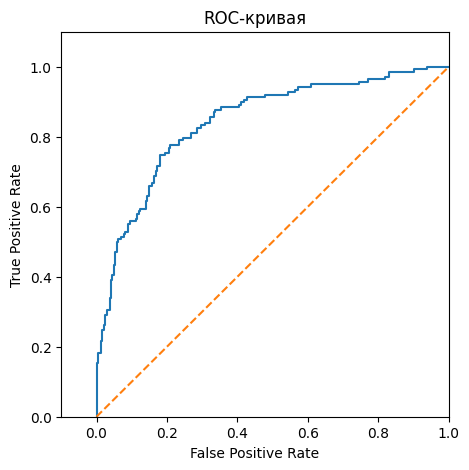

In [154]:
def make_roc_curve(target_test, predicted_test):
    fpr, tpr, thresholds = roc_curve(target_test, predicted_test)

    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([-0.1, 1.0])
    plt.ylim([0.0, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()
    
make_roc_curve(target_test, probabilities_one_test)

### Построим матрицу ошибок

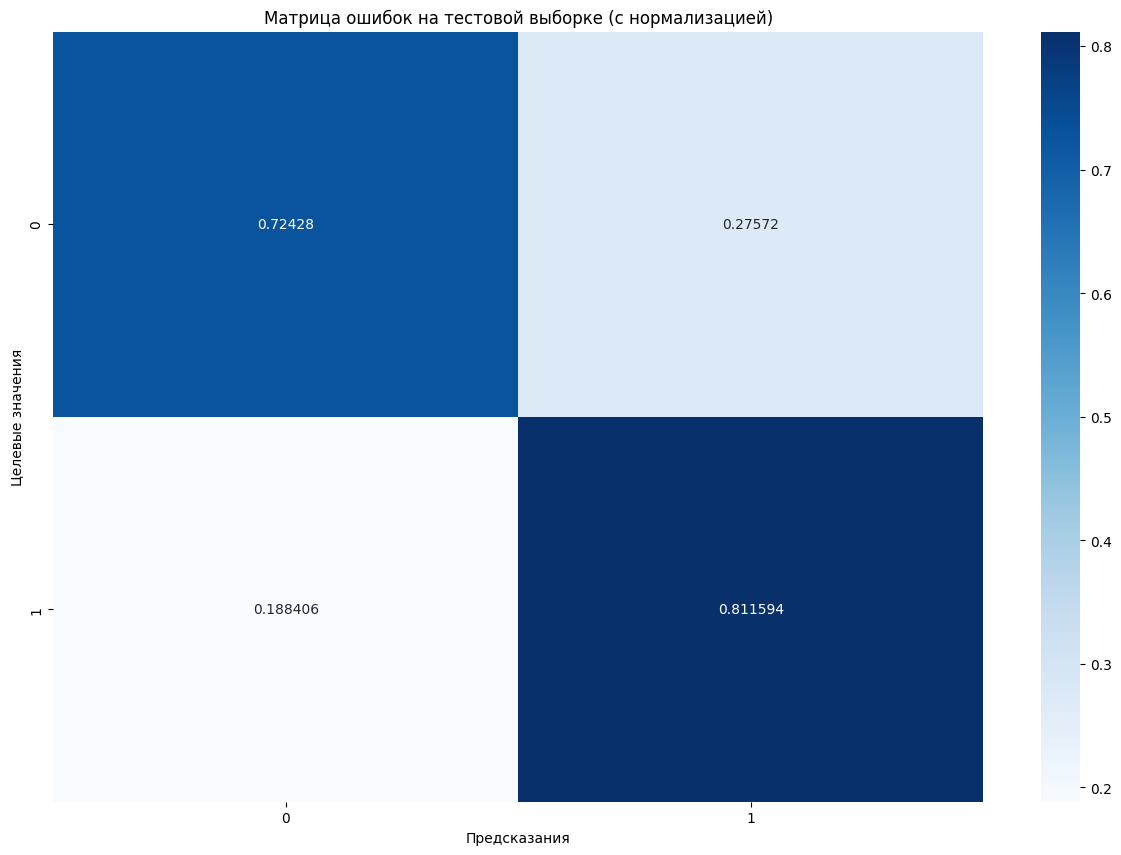

In [155]:
cm = confusion_matrix(target_test, prediction_test, normalize='true')
plt.subplots( figsize=(15, 10))
sns.heatmap(cm, annot=True,  fmt='g', cmap='Blues')

plt.title('Матрица ошибок на тестовой выборке (с нормализацией)', fontsize=12 )
plt.xlabel('Предсказания')
plt.ylabel('Целевые значения')
plt.show()

По Матрице ошибок видна следующая картина:

- `True Positive` (истинно-положительное решение): репетитор оказался нехорошим и прогноз модели это предсказал *(Предсказания 0 : Целевые значения 0)* - 72%
- `False Positive` (ложноположительное решение): ошибка 1-го рода, ML-модель предсказала что репетитор нехороший, а на самом деле он хороший *(Предсказания 1 : Целевые значения 0)* - 28%
- `False Negative` (ложноотрицательное решение): ошибка 2-го рода – ML-модель предсказала, что репетитор хороший, но на самом деле он нехороший *(Предсказания 0 : Целевые значения 1)* - 19%
- `True Negative` (истинно-отрицательное решение): репетитор оказался хорошим и прогноз модели это предсказал *(Предсказания 1 : Целевые значения 1)* - 81%

Нам важно минимизировать ложноотрицательные ошибки (0.19) (репетитор был классифицирован как хороший, но фактически он нехороший). Поэтому важно повысить полноту определения целевого класса (1). Для этого подберем новое пороговое значение. Визуализируем измение порога присвоения класса и подберем оптимальный порог с учетом метрики точности **Accuracy** и полноты **Recall**.

In [156]:
for threshold in np.arange(0, 1.0, 0.02):
    predict = probabilities_one_test > threshold 
    accuracy_test = accuracy_score(target_test, predict)
    recall_test = recall_score(target_test, predict)

    print("Порог = {:.2f} | Точность (Accuracy) = {:.3f}, Полнота (Recall) = {:.3f}".format(
        threshold, accuracy_test, recall_test))

Порог = 0.00 | Точность (Accuracy) = 0.362, Полнота (Recall) = 1.000
Порог = 0.02 | Точность (Accuracy) = 0.362, Полнота (Recall) = 1.000
Порог = 0.04 | Точность (Accuracy) = 0.362, Полнота (Recall) = 1.000
Порог = 0.06 | Точность (Accuracy) = 0.362, Полнота (Recall) = 1.000
Порог = 0.08 | Точность (Accuracy) = 0.362, Полнота (Recall) = 1.000
Порог = 0.10 | Точность (Accuracy) = 0.362, Полнота (Recall) = 1.000
Порог = 0.12 | Точность (Accuracy) = 0.362, Полнота (Recall) = 1.000
Порог = 0.14 | Точность (Accuracy) = 0.362, Полнота (Recall) = 1.000
Порог = 0.16 | Точность (Accuracy) = 0.362, Полнота (Recall) = 1.000
Порог = 0.18 | Точность (Accuracy) = 0.362, Полнота (Recall) = 1.000
Порог = 0.20 | Точность (Accuracy) = 0.362, Полнота (Recall) = 1.000
Порог = 0.22 | Точность (Accuracy) = 0.365, Полнота (Recall) = 1.000
Порог = 0.24 | Точность (Accuracy) = 0.373, Полнота (Recall) = 1.000
Порог = 0.26 | Точность (Accuracy) = 0.381, Полнота (Recall) = 1.000
Порог = 0.28 | Точность (Accuracy)

Подобрали такой порог, чтобы **Accuracy** не слишком снизилась, а **Recall** максимально увеличилась - получим 0.46. Применим новый порог:

In [157]:
# применим выбранный порог
prediction_2 = np.where(probabilities_one_test >= 0.46, 1, 0)
f1_test_2 = f1_score(target_test, prediction_2)
roc_auc_test_2 = roc_auc_score(target_test, probabilities_one_test)
accuracy_test_2 = accuracy_score(target_test, prediction_2)
recall_test_2 = recall_score(target_test, prediction_2)

print("Результат тестовой метрики F1 для модели CatBoostClassifier:", round(f1_test_2, 4))
print("Результат тестовой метрики ROC-AUC для модели CatBoostClassifier:", round(roc_auc_test_2, 2))
print("Результат тестовой метрики Accuracy для модели CatBoostClassifier:", round(accuracy_test_2, 2))
print("Результат тестовой метрики Recall для модели CatBoostClassifier:", round(recall_test_2, 2))

Результат тестовой метрики F1 для модели CatBoostClassifier: 0.6833
Результат тестовой метрики ROC-AUC для модели CatBoostClassifier: 0.84
Результат тестовой метрики Accuracy для модели CatBoostClassifier: 0.7
Результат тестовой метрики Recall для модели CatBoostClassifier: 0.89


Построим Матрицу ошибок с новым порогом

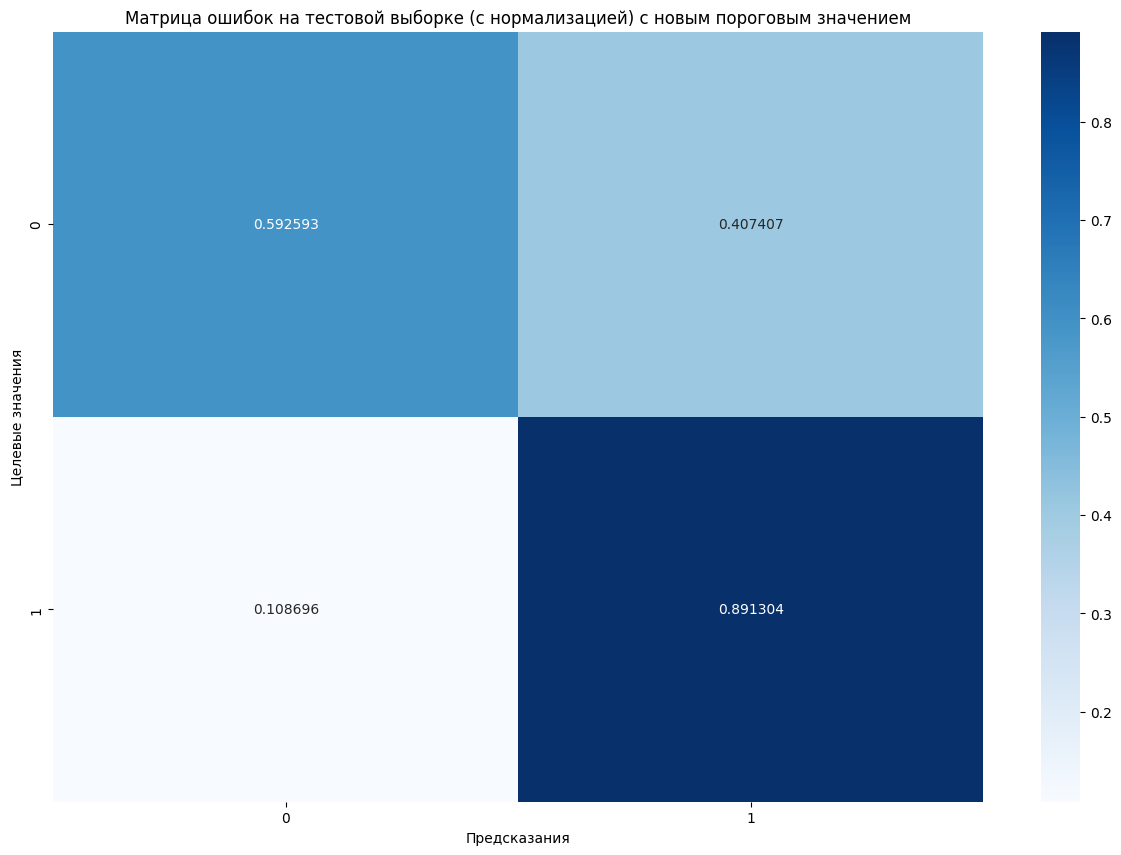

In [163]:
cm_2 = confusion_matrix(target_test, prediction_2,  normalize='true')
plt.subplots( figsize=(15, 10))
sns.heatmap(cm_2, annot=True,  fmt='g', cmap='Blues')

plt.title('Матрица ошибок на тестовой выборке (с нормализацией) с новым пороговым значением', fontsize=12 )
plt.xlabel('Предсказания')
plt.ylabel('Целевые значения')
plt.show()

Видим, что получилось уменьшить ложноотрицательные ошибки - ошибка в определении 1 класса снизилась на 0.08. При этом точность **Accuracy** модели уменьшилось на 0.06, а полнота модели **Recall** увеличилась на 0.08. На метрику **ROC-AUC** изменение порога никак не повлияло, так как она рассчитана на вероятностях. Таким образом, порог определения класса можно корректировать в зависимости от бизнес-целей.

### Построим диаграмму важности признаков

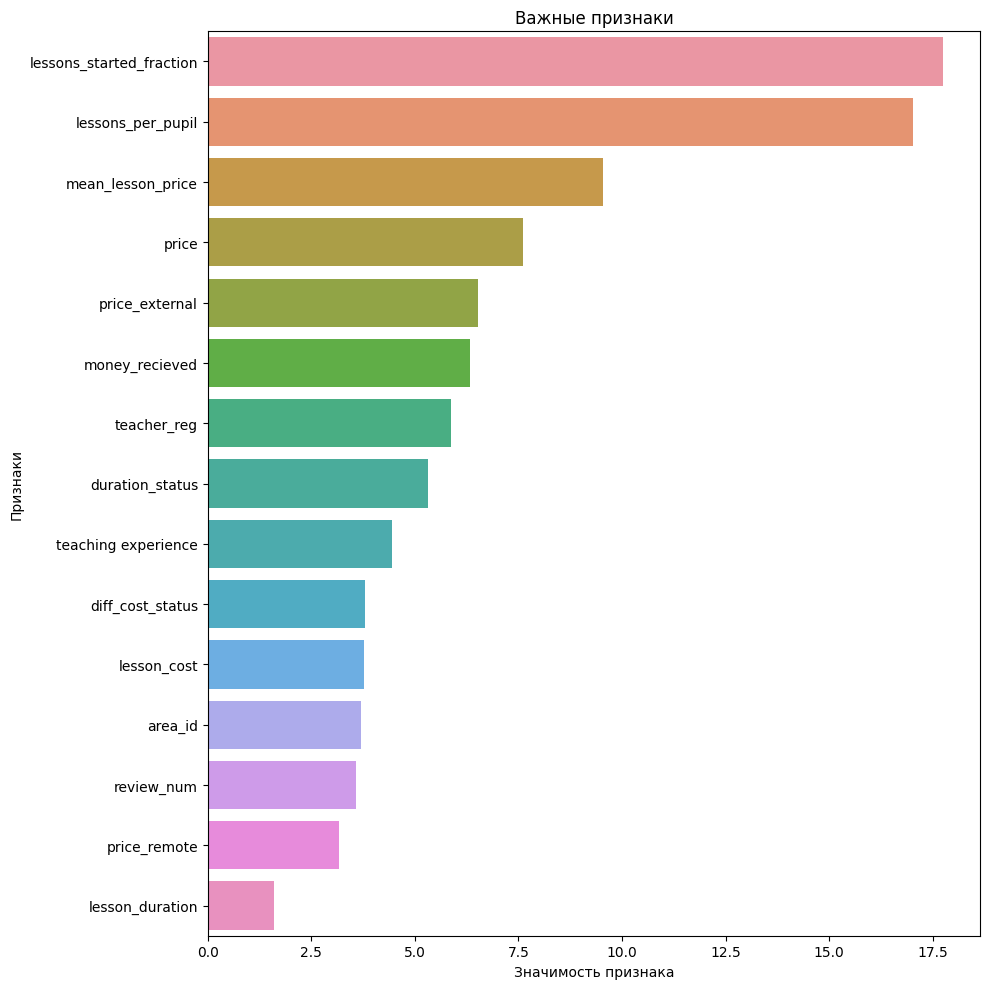

In [159]:
feature_imp = pd.DataFrame(
    sorted(zip(model_CBC._final_estimator.feature_importances_, features.columns)), 
    columns=['Значимость признака','Признаки'])

plt.figure(figsize=(10, 10))
sns.barplot(x="Значимость признака", 
            y="Признаки", 
            data=feature_imp.sort_values(by="Значимость признака", ascending=False))
plt.title('Важные признаки')
plt.tight_layout()
plt.show()

In [160]:
a = model_CBC._final_estimator.feature_importances_
np.sort(a)

array([ 1.59560896,  3.17290456,  3.57132234,  3.70218311,  3.77629051,
        3.80172165,  4.43478783,  5.30692075,  5.86562266,  6.3310187 ,
        6.51340531,  7.61977331,  9.53910391, 17.01689613, 17.75244028])

Видим, что важными признаками для обучения модели являются:

- lessons_started_fraction 17.75%
- lessons_per_pupil 17.02%
- mean_lesson_price 9.54%
- price 7.62%
- price_external 6.51%
- money_recieved 6.33%
- teacher_reg 5.87%
- duration_status 4.43%
- teaching experience 3.80%
- diff_cost_status 3.78% 

Остальные признаки имеют низкую важность, при обучении их можно не учитывать.

## Отчет по итогам исследования

**Задача исследования:** Разработать модель, которая по имеющейся информации о репетиторе и проведенных им занятий будет классифицировать репетиторов на платящих и неэффективных. Оценка качества модели будет производиться с использованием метрики `F1`.

### Ключевые шаги работы над исследованием

**В данном проекте были реализованы следующие этапы работ:**

1. Загружены данные:

- *lesson_course.feather* - информация об учениках
- *lessons.feather* - информация о занятиях
- *orders.feather* - информация о заявках
- *teacher_prices.feather* - информация о ценах на занятия с репетиторами
- *teachers_info.feather* - информация о репетиторах
- *teachers.feather* - статистика по репетиторам 

2. Объединены данные в общую таблицу по столбцам `teacher_id` и `client_id`.
3. Проведена предобработка данных:

- заполнение пропусков после объединения таблиц;
- проверка на наличие дубликатов;
- изменение типа данных для корректного дальнейшего исследования.

4. Проведен исследовательский анализ данных:

- проведена оценка дисбаланса целевого признака.
- выделены новые признаки:
  - ученик не отмечен как завершенный, а оплат нет
  - низкая цена урока
  - случай, когда статус заявки - договорились о занятиях, оплат нет более недели
  - случай, когда идет разная стоимость уроков с одним учеником
  - случай, когда продолжительность урока не совпадает с фактически проведенным временем урока
  - несоответствие цены в заявке и у ученика
- собран датасет из признаков для дальнейшего обучения моделей.
- проведена проверка на мультиколлинеарность признаков, и выделены финальные столбцы для исследования.

5. Подготовка данных для построения модели:

- общая таблица поделена на выборки: `features (признаки)` и `target (целевой признак)`.
- выделены тренировочная выборка и тестовая выборка в соотношении 75:25 соответственно.
- признаки закодированы отдельно для логистической регрессии (`LogisticRegression`). Для `RandomForestClassifier` и `CatBoostClassifier` кодировка не требуется, так как в датасете нет категориальных признаков.

6. Построение моделей, подбор гиперпараметров и оценка их качества:

- Были построены следующие модели:
  - Логистическая регрессия (`LogisticRegression`)
  - Случайный лес (`RandomForestClassifier`)
  - `CatBoostClassifier`

- оценка качества модели проходила на метрике *F1*.

7. Выбор и тестирование наилучшей по качеству модели.

8. Построение матрицы ошибок и подбор порогового значения

9. Диаграмма важности признаков.


### Предобработка данных

Основная проблема предобработки данных состояла в том, что после объединения таблиц появились пропуски и множество дубликатов, так как на одного учителя может приходиться множество учеников и у каждого ученика может быть множество занятий. 

Что было сделано:

- изменен тип данных на datetime для столбцов с датами и временем.
- были созданы новые столбцы:

  - с днями, прошедшими от заявки до урока (days_from_order_to_lesson)
  - с возрастом репетитора (teacher_age)
  - с опытом преподавания учителя в годах (teaching experience)
  - с количеством лет, прошедших после регистрации на платформе (teacher_reg)
  - с разницей между началом и концом занятия в минутах (time_from_to)
  - с разницей между прошедшим уроком и последним визитом (days_after_lesson)


### Признаки и целевой признак

1. Целевой признак (столбец `blocked`):

В данных целевого признака был выявлен дисбаланс

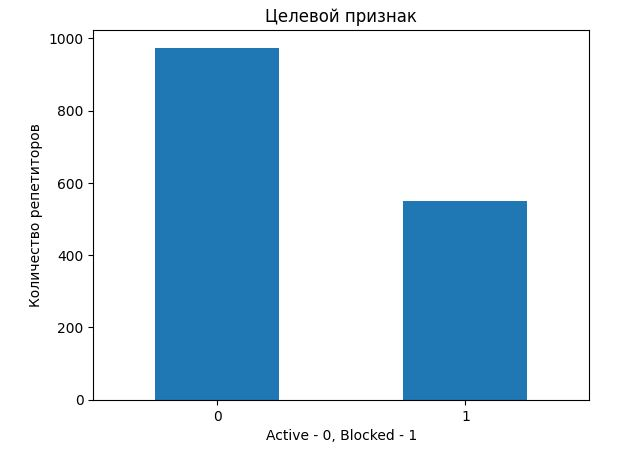

Классы не сбалансированы. Это значит, что при обучении модели перевес будет в сторону более многочисленного класса - 0. Нашей же целью является выявление класса 1 - недобросовестных репетиторов.

При выборе целевой метрики качества будем учитывать несбалансированность классов - приоритет отдадим метрике - **F1**.

**Провели корреляционный анализ с помощью `phik`.**
Это позволило уменьшить количество признаков для обучения за счет удаления признаков с мультиколлинеарностью. 

Мультиколлинеарность — корреляция независимых переменных, которая затрудняет оценку и анализ общего результата.

В машинном обучении мультиколлинеарность может стать причиной переобучаемости модели, что приведет к неверному результату. Кроме того, избыточные коэффициенты увеличивают сложность модели машинного обучения, а значит, время ее тренировки возрастает.

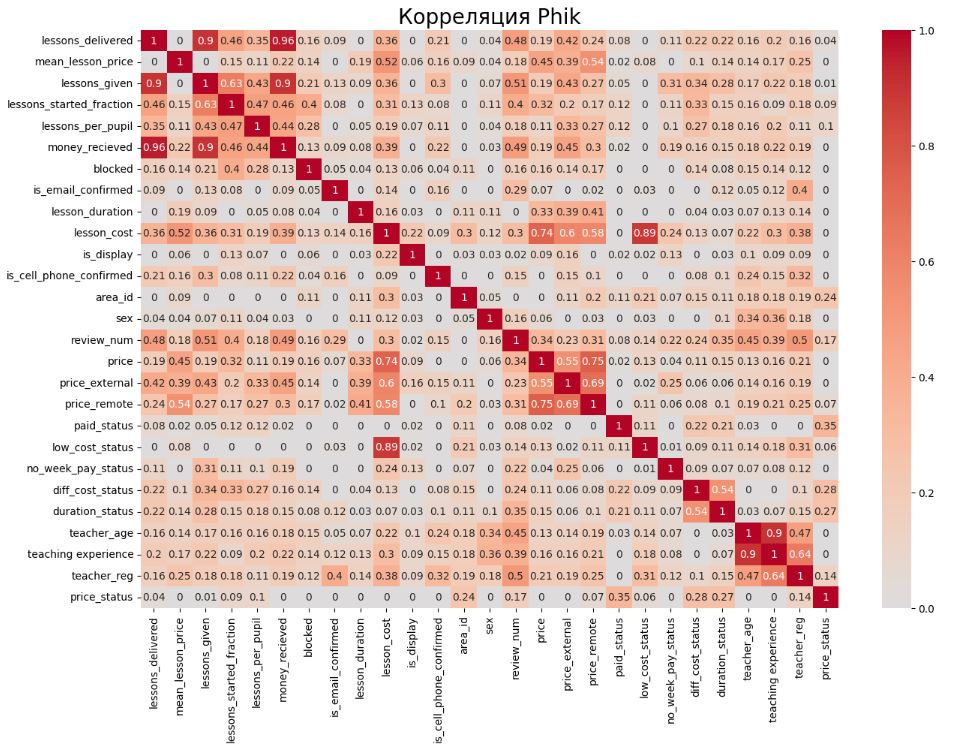

В итоге, чтобы исключить мультиколлинеарность оставили следующие признаки:

- money_recieved 
- mean_lesson_price
- lessons_started_fraction
- lessons_per_pupil
- lesson_duration
- lesson_cost
- area_id
- review_num 
- price
- price_external 
- price_remote
- diff_cost_status
- duration_status
- teaching experience
- teacher_reg

### Исследованные модели

- Были построены следующие модели:
  - Логистическая регрессия (`LogisticRegression`)
  - Случайный лес (`RandomForestClassifier`)
  - `CatBoostClassifier`

Метрикой качества модели является *F1*.
На тренировочной выборке данные модели при лучших гиперпараметрах показали следующие результаты:

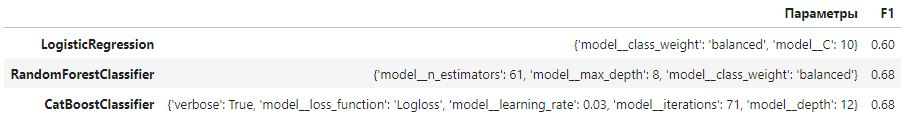

Наилучшей по качеству стал алгоритм `CatBoostClassifier`. Выбрали его за основу нашей модели обучения и проверили на тестовой выборке.

### Итоговая метрика на тестовой выборке

**1. На тестовой выборке получили следующие значения:**

- F1 0.71
- ROC-AUC 0.84
- Accuracy 0.76
- Recall 0.81

**2. Построили ROC-кривую**

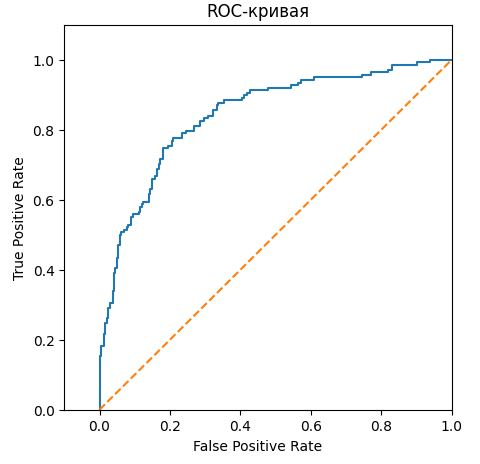


**3. Построили матрицу ошибок:**

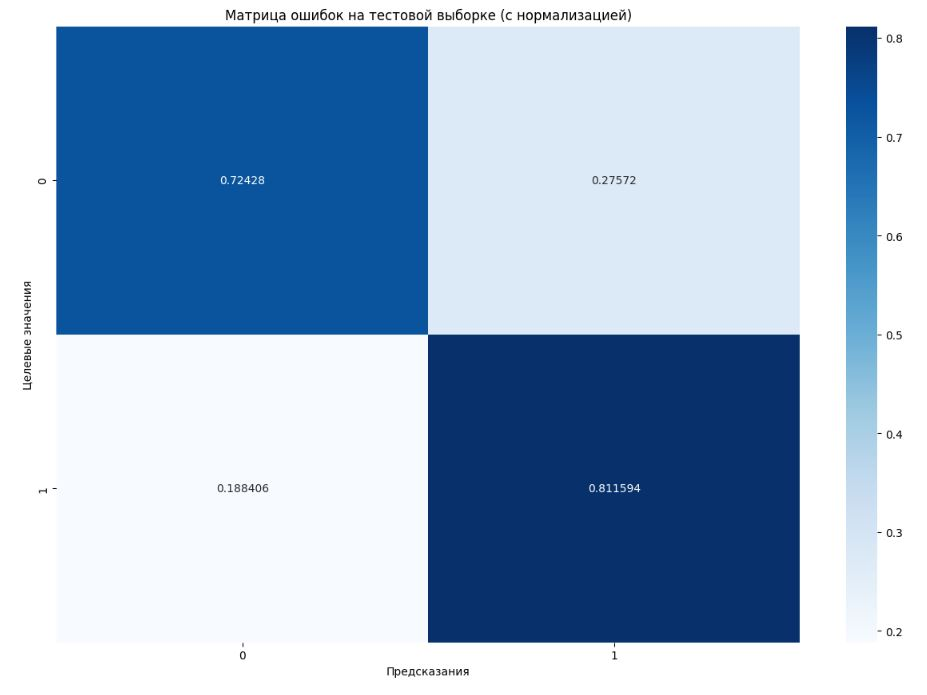

По Матрице ошибок видна следующая картина:

- `True Positive` (истинно-положительное решение): репетитор оказался нехорошим и прогноз модели это предсказал *(Предсказания 0 : Целевые значения 0)* - 72%
- `False Positive` (ложноположительное решение): ошибка 1-го рода, ML-модель предсказала что репетитор нехороший, а на самом деле он хороший *(Предсказания 1 : Целевые значения 0)* - 28%
- `False Negative` (ложноотрицательное решение): ошибка 2-го рода – ML-модель предсказала, что репетитор хороший, но на самом деле он нехороший *(Предсказания 0 : Целевые значения 1)* - 19%
- `True Negative` (истинно-отрицательное решение): репетитор оказался хорошим и прогноз модели это предсказал *(Предсказания 1 : Целевые значения 1)* - 81%

Нам важно минимизировать ложноотрицательные ошибки (0.19) (репетитор был классифицирован как хороший, но фактически он нехороший). Поэтому важно повысить полноту определения целевого класса (1). Для этого подберем новое пороговое значение.

С новым пороговым значением 0.46 получили следующую матрицу ошибок:

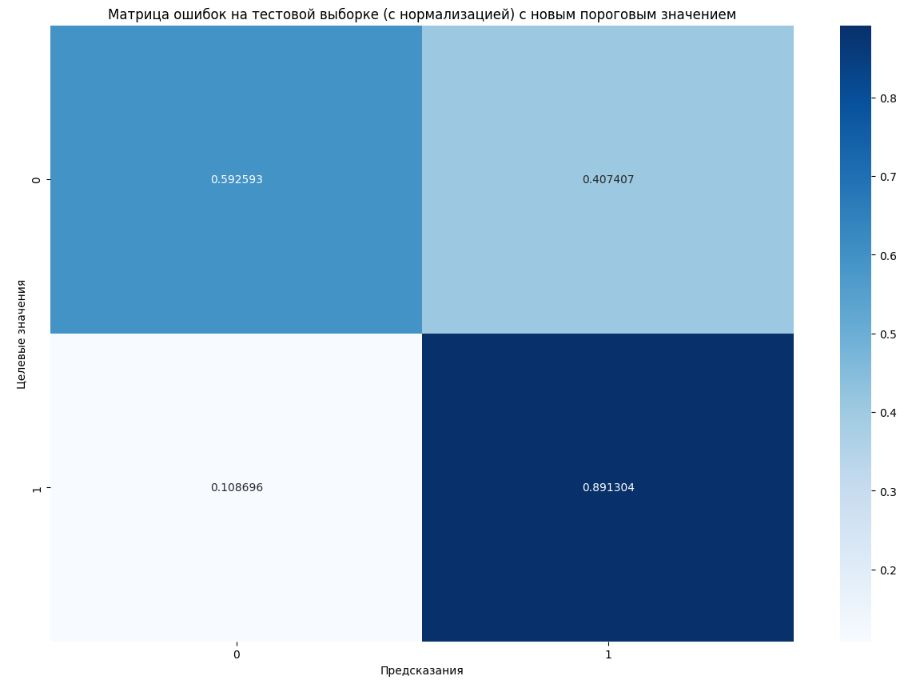

Видим, что получилось уменьшить ложноотрицательные ошибки - ошибка в определении 1 класса снизилась на 0.08. Таким образом, порог определения класса можно корректировать в зависимости от бизнес-целей.


**4. Оценка важности признаков:**

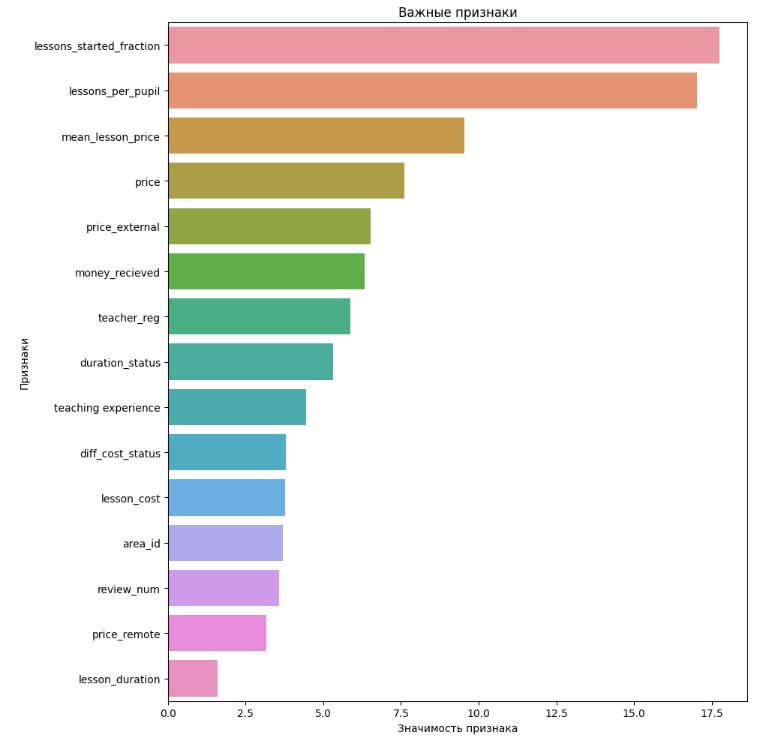

Видим, что важными признаками для обучения модели являются:

- lessons_started_fraction 17.75%
- lessons_per_pupil 17.02%
- mean_lesson_price 9.54%
- price 7.62%
- price_external 6.51%
- money_recieved 6.33%
- teacher_reg 5.87%
- duration_status 4.43%
- teaching experience 3.80%
- diff_cost_status 3.78% 

Остальные признаки имеют низкую важность, при обучении их можно не учитывать.

### Заключение

- В ходе выполнения проекта поставленные задачи были выполнены. 

- Реализация закрепленных в плане задач, позволила:

1. построить модель машинного обучения:

   - выбрана лучшая модель - `CatBoostClassifier` с гиперпараметрами {'verbose': True, 'model__loss_function': 'Logloss', 'model__learning_rate': 0.03, 'model__iterations': 71, 'model__depth': 12};
   - достигнута целевая метрика **F1** = 0.68 (результаты модели на тестовой выборке равны 0.71).
   
2. подобрать такой порог (0.46), чтобы **Accuracy** не слишком снизилась, а **Recall** максимально увеличилась.
   
3. определить важные признаки для обучения модели.